In [0]:
# Potrebno za Google Colab

#! unzip UniProt\ cist.zip
#! mkdir ../data
#! mv UniProt\ cist ../data/


In [0]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn import preprocessing as prep
from sklearn import model_selection as ms
from sklearn import linear_model as lm
from sklearn import metrics as met
from sklearn.utils import class_weight as cw
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import losses, optimizers, initializers, regularizers, activations
from keras import metrics as ker_met
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from timeit import default_timer as timer
from datetime import timedelta

%matplotlib inline
#plt.style.use ('dark_background')


In [0]:
# Ucitavanje podataka koji su vec kreirani pomocu Main_1 fajla, na isti nacin

# Krecemo sa ucitavanjem podataka i vizualizacijom istih
poz_putanja_ulaza = os.path.join ('..', 'data', 'UniProt cist', 'Pozitivni', 'POZ_FINALNO.csv')
neg_putanja_ulaza = os.path.join ('..', 'data', 'UniProt cist', 'Negativni', 'NEG_FINALNO.csv')

df_poz = pd.read_csv (poz_putanja_ulaza, sep = '\t', index_col = 0)
df_neg = pd.read_csv (neg_putanja_ulaza, sep = '\t', index_col = 0)


In [35]:
df_poz


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9SSS9,25668.2531,-0.049145,0.051282,42.751709,0.098291,0.000000,0.047009,0.055556,0.038462,0.034188,0.004274,0.068376,0.072650,0.106838,0.021368,0.051282,0.029915,0.068376,0.042735,0.089744,0.068376,0.089744,0.000000,0.012821,9.045593,0.316239,0.205128,0.282051,3,3,0.012821,0.012821,0.427350,0.277778,0.316239,0.465812,0.119658,0.021368,0.102564,0.119658,0.158120,1,1,1
O04151,48526.7256,-1.009412,0.105882,31.455082,0.072941,0.007059,0.120000,0.122353,0.037647,0.051765,0.016471,0.044706,0.122353,0.054118,0.009412,0.035294,0.061176,0.016471,0.009412,0.054118,0.051765,0.044706,0.030588,0.037647,4.457947,0.249412,0.202353,0.258824,-47,47,-0.110588,0.110588,0.329412,0.157647,0.258824,0.367059,0.148235,0.016471,0.242353,0.051765,0.105882,1,3,1
Q9LV16,77740.2127,-0.460206,0.091043,42.948752,0.046990,0.017621,0.048458,0.080764,0.042584,0.058737,0.027900,0.044053,0.083700,0.096916,0.023495,0.026432,0.049927,0.038179,0.057269,0.092511,0.045521,0.070485,0.022026,0.026432,8.660339,0.302496,0.227606,0.248164,8,8,0.011747,0.011747,0.367107,0.202643,0.320117,0.409692,0.168869,0.041116,0.129222,0.064611,0.138032,1,1,1
Q9SE50,60458.5342,-0.509659,0.140152,26.184129,0.053030,0.015152,0.070076,0.051136,0.058712,0.089015,0.041667,0.043561,0.073864,0.077652,0.015152,0.043561,0.049242,0.034091,0.041667,0.054924,0.043561,0.062500,0.024621,0.056818,6.744568,0.323864,0.236742,0.196970,-3,3,-0.005682,0.005682,0.375000,0.176136,0.329545,0.433712,0.157197,0.030303,0.121212,0.077652,0.098485,1,3,1
Q9SYQ8,107596.6100,0.019184,0.077551,30.612449,0.047959,0.014286,0.039796,0.057143,0.046939,0.087755,0.028571,0.072449,0.047959,0.136735,0.021429,0.073469,0.050000,0.016327,0.037755,0.076531,0.058163,0.056122,0.006122,0.024490,6.233948,0.342857,0.287755,0.263265,-11,11,-0.011224,0.011224,0.451020,0.224490,0.319388,0.497959,0.114286,0.035714,0.096939,0.089796,0.134694,1,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9SU13,43447.8938,-0.076179,0.071960,38.811166,0.091811,0.007444,0.074442,0.029777,0.039702,0.059553,0.022333,0.054591,0.071960,0.094293,0.022333,0.044665,0.039702,0.032258,0.022333,0.094293,0.086849,0.079404,0.002481,0.029777,6.145325,0.300248,0.238213,0.238213,-4,4,-0.009926,0.009926,0.419355,0.258065,0.342432,0.459057,0.116625,0.029777,0.104218,0.076923,0.181141,1,4,1
Q3E9A4,53221.7554,-0.192275,0.100858,62.873433,0.060086,0.010730,0.036481,0.055794,0.049356,0.040773,0.042918,0.053648,0.049356,0.103004,0.027897,0.053648,0.068670,0.025751,0.064378,0.096567,0.025751,0.083691,0.015021,0.036481,9.230896,0.341202,0.259657,0.246781,10,10,0.021459,0.021459,0.409871,0.201717,0.334764,0.459227,0.156652,0.038627,0.092275,0.079399,0.122318,1,3,1
O80522,40476.1001,0.070000,0.105405,31.570270,0.062162,0.027027,0.045946,0.029730,0.059459,0.097297,0.027027,0.067568,0.045946,0.113514,0.027027,0.064865,0.045946,0.027027,0.035135,0.091892,0.035135,0.051351,0.005405,0.040541,7.987854,0.33783

In [36]:
df_neg


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
F4I443,79689.1581,-0.586975,0.061625,48.451849,0.070028,0.036415,0.061625,0.071429,0.025210,0.047619,0.030812,0.043417,0.077031,0.088235,0.018207,0.051821,0.053221,0.039216,0.049020,0.100840,0.046218,0.053221,0.012605,0.023810,6.533630,0.246499,0.253501,0.247899,-5,5,-0.007003,0.007003,0.355742,0.238095,0.359944,0.380952,0.156863,0.054622,0.133053,0.091036,0.147059,1,3,0
Q8RXD3,34806.9132,-0.550968,0.064516,54.291645,0.061290,0.029032,0.048387,0.116129,0.029032,0.051613,0.025806,0.041935,0.070968,0.100000,0.019355,0.038710,0.064516,0.045161,0.038710,0.087097,0.038710,0.058065,0.012903,0.022581,4.984070,0.264516,0.241935,0.296774,-17,17,-0.054839,0.054839,0.377419,0.209677,0.319355,0.406452,0.135484,0.048387,0.164516,0.083871,0.125806,0,0,0
P04778,28240.8071,0.020974,0.108614,24.637828,0.123596,0.003745,0.041199,0.056180,0.059925,0.123596,0.011236,0.026217,0.048689,0.097378,0.026217,0.037453,0.067416,0.014981,0.033708,0.074906,0.037453,0.067416,0.022472,0.026217,5.466858,0.299625,0.303371,0.303371,-4,4,-0.014981,0.014981,0.505618,0.164794,0.254682,0.565543,0.093633,0.029963,0.097378,0.052434,0.112360,0,0,0
Q9FLD5,60346.9487,-0.847276,0.095331,51.946342,0.042802,0.007782,0.062257,0.128405,0.042802,0.046693,0.017510,0.073930,0.132296,0.077821,0.023346,0.038911,0.021401,0.023346,0.050584,0.066148,0.054475,0.036965,0.013619,0.038911,6.278381,0.284047,0.173152,0.272374,-4,4,-0.007782,0.007782,0.299611,0.182879,0.284047,0.342412,0.200389,0.031128,0.190661,0.062257,0.120623,1,3,0
Q9M022,28049.1504,-0.364463,0.099174,52.350455,0.057851,0.041322,0.061983,0.070248,0.033058,0.045455,0.020661,0.061983,0.074380,0.123967,0.020661,0.033058,0.045455,0.024793,0.074380,0.066116,0.041322,0.037190,0.012397,0.053719,8.450012,0.322314,0.190083,0.272727,4,4,0.016529,0.016529,0.371901,0.165289,0.314050,0.404959,0.169421,0.061983,0.132231,0.057851,0.107438,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8RXF8,72321.5750,-0.249228,0.081790,52.203410,0.086420,0.020062,0.066358,0.075617,0.046296,0.050926,0.010802,0.052469,0.052469,0.095679,0.020062,0.032407,0.058642,0.038580,0.063272,0.075617,0.047840,0.070988,0.007716,0.027778,5.167542,0.300926,0.217593,0.277778,-17,17,-0.026235,0.026235,0.415123,0.194444,0.280864,0.461420,0.126543,0.040123,0.141975,0.070988,0.123457,1,1,0
P93282,13248.7403,-0.405785,0.049587,44.333884,0.057851,0.016529,0.049587,0.049587,0.016529,0.016529,0.016529,0.057851,0.033058,0.082645,0.024793,0.041322,0.090909,0.024793,0.057851,0.148760,0.132231,0.049587,0.000000,0.033058,6.063782,0.239669,0.297521,0.214876,-1,1,-0.008264,0.008264,0.355372,0.347107,0.438017,0.371901,0.107438,0.041322,0.099174,0.066116,0.280992,1,1,0
Q9LJK3,34698.4268,0.412500,0.175676,31.229764,0.081081,0.020270,0.054054,0.043919,0.077703,0.040541,0.023649,0.074324,0.050676,0.128378,0.037162,0.013514,0.020270,0.016892,0.047297,0.070946,0.033784,0.067568,0.033784,0.064189,7.034485,0.44594

In [37]:
# Kreiranje DataFrame-a koji sadrzi i pozitivne i negativne proteine
# verify_integrity parametar obezbedjuje proveru jedinstvenosti indeksa
# Samim tim se zapravo vidi da nema preklapanja iz pozitivnih i negativnih skupova podataka

df_sve = pd.concat([df_poz,df_neg], ignore_index=False, verify_integrity = True)
df_sve


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9SSS9,25668.2531,-0.049145,0.051282,42.751709,0.098291,0.000000,0.047009,0.055556,0.038462,0.034188,0.004274,0.068376,0.072650,0.106838,0.021368,0.051282,0.029915,0.068376,0.042735,0.089744,0.068376,0.089744,0.000000,0.012821,9.045593,0.316239,0.205128,0.282051,3,3,0.012821,0.012821,0.427350,0.277778,0.316239,0.465812,0.119658,0.021368,0.102564,0.119658,0.158120,1,1,1
O04151,48526.7256,-1.009412,0.105882,31.455082,0.072941,0.007059,0.120000,0.122353,0.037647,0.051765,0.016471,0.044706,0.122353,0.054118,0.009412,0.035294,0.061176,0.016471,0.009412,0.054118,0.051765,0.044706,0.030588,0.037647,4.457947,0.249412,0.202353,0.258824,-47,47,-0.110588,0.110588,0.329412,0.157647,0.258824,0.367059,0.148235,0.016471,0.242353,0.051765,0.105882,1,3,1
Q9LV16,77740.2127,-0.460206,0.091043,42.948752,0.046990,0.017621,0.048458,0.080764,0.042584,0.058737,0.027900,0.044053,0.083700,0.096916,0.023495,0.026432,0.049927,0.038179,0.057269,0.092511,0.045521,0.070485,0.022026,0.026432,8.660339,0.302496,0.227606,0.248164,8,8,0.011747,0.011747,0.367107,0.202643,0.320117,0.409692,0.168869,0.041116,0.129222,0.064611,0.138032,1,1,1
Q9SE50,60458.5342,-0.509659,0.140152,26.184129,0.053030,0.015152,0.070076,0.051136,0.058712,0.089015,0.041667,0.043561,0.073864,0.077652,0.015152,0.043561,0.049242,0.034091,0.041667,0.054924,0.043561,0.062500,0.024621,0.056818,6.744568,0.323864,0.236742,0.196970,-3,3,-0.005682,0.005682,0.375000,0.176136,0.329545,0.433712,0.157197,0.030303,0.121212,0.077652,0.098485,1,3,1
Q9SYQ8,107596.6100,0.019184,0.077551,30.612449,0.047959,0.014286,0.039796,0.057143,0.046939,0.087755,0.028571,0.072449,0.047959,0.136735,0.021429,0.073469,0.050000,0.016327,0.037755,0.076531,0.058163,0.056122,0.006122,0.024490,6.233948,0.342857,0.287755,0.263265,-11,11,-0.011224,0.011224,0.451020,0.224490,0.319388,0.497959,0.114286,0.035714,0.096939,0.089796,0.134694,1,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8RXF8,72321.5750,-0.249228,0.081790,52.203410,0.086420,0.020062,0.066358,0.075617,0.046296,0.050926,0.010802,0.052469,0.052469,0.095679,0.020062,0.032407,0.058642,0.038580,0.063272,0.075617,0.047840,0.070988,0.007716,0.027778,5.167542,0.300926,0.217593,0.277778,-17,17,-0.026235,0.026235,0.415123,0.194444,0.280864,0.461420,0.126543,0.040123,0.141975,0.070988,0.123457,1,1,0
P93282,13248.7403,-0.405785,0.049587,44.333884,0.057851,0.016529,0.049587,0.049587,0.016529,0.016529,0.016529,0.057851,0.033058,0.082645,0.024793,0.041322,0.090909,0.024793,0.057851,0.148760,0.132231,0.049587,0.000000,0.033058,6.063782,0.239669,0.297521,0.214876,-1,1,-0.008264,0.008264,0.355372,0.347107,0.438017,0.371901,0.107438,0.041322,0.099174,0.066116,0.280992,1,1,0
Q9LJK3,34698.4268,0.412500,0.175676,31.229764,0.081081,0.020270,0.054054,0.043919,0.077703,0.040541,0.023649,0.074324,0.050676,0.128378,0.037162,0.013514,0.020270,0.016892,0.047297,0.070946,0.033784,0.067568,0.033784,0.064189,7.034485,0.445

In [38]:
# Permutovanje vrsta ovakvog DataFrame-a tako da nemamo prvo pozitivne pa negativne, vec proizvoljno
df_sve = df_sve.reindex (np.random.permutation (df_sve.index))
df_sve


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9LFH0,164104.0328,0.052069,0.116552,44.210924,0.066207,0.011034,0.046897,0.057241,0.062069,0.060000,0.016552,0.073103,0.054483,0.100000,0.033103,0.029655,0.037241,0.037931,0.047586,0.079310,0.062759,0.070345,0.016552,0.037931,6.808777,0.360000,0.206207,0.256552,-3,3,-0.002069,0.002069,0.406897,0.209655,0.324828,0.468966,0.118621,0.044138,0.104138,0.067586,0.142069,1,3,0
Q9SLL2,41769.4987,-1.046995,0.071038,62.615874,0.043716,0.010929,0.068306,0.068306,0.038251,0.021858,0.027322,0.049180,0.076503,0.057377,0.008197,0.073770,0.038251,0.019126,0.090164,0.163934,0.071038,0.040984,0.002732,0.030055,9.352356,0.218579,0.297814,0.177596,11,11,0.030055,0.030055,0.251366,0.327869,0.407104,0.289617,0.193989,0.019126,0.136612,0.092896,0.234973,1,5,0
P49572,44576.7826,-0.204229,0.064677,40.106468,0.082090,0.012438,0.049751,0.087065,0.034826,0.072139,0.012438,0.072139,0.069652,0.097015,0.017413,0.037313,0.047264,0.032338,0.067164,0.072139,0.024876,0.082090,0.007463,0.022388,6.985046,0.315920,0.228856,0.283582,0,0,0.000000,0.000000,0.452736,0.166667,0.238806,0.487562,0.149254,0.029851,0.136816,0.069652,0.097015,1,3,0
Q9LUS9,40885.9067,-0.021490,0.148997,43.644126,0.040115,0.051576,0.065903,0.054441,0.071633,0.034384,0.008596,0.091691,0.065903,0.097421,0.005731,0.051576,0.042980,0.020057,0.054441,0.071633,0.037249,0.057307,0.025788,0.051576,6.797180,0.395415,0.200573,0.197708,0,0,0.000000,0.000000,0.363897,0.180516,0.323782,0.435530,0.128940,0.057307,0.120344,0.071633,0.108883,1,2,0
Q4PSY4,37767.8112,-0.222590,0.126506,46.701506,0.069277,0.018072,0.057229,0.075301,0.042169,0.045181,0.018072,0.051205,0.060241,0.078313,0.030120,0.036145,0.093373,0.024096,0.030120,0.066265,0.036145,0.084337,0.021084,0.063253,4.928284,0.340361,0.240964,0.253012,-14,14,-0.042169,0.042169,0.421687,0.162651,0.313253,0.463855,0.108434,0.048193,0.132530,0.060241,0.102410,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9LUT0,39561.7338,-0.302198,0.068681,26.848104,0.093407,0.016484,0.057692,0.038462,0.024725,0.087912,0.035714,0.035714,0.060440,0.093407,0.016484,0.035714,0.074176,0.043956,0.054945,0.063187,0.035714,0.087912,0.005495,0.038462,8.973694,0.285714,0.260989,0.241758,7,7,0.019231,0.019231,0.472527,0.178571,0.291209,0.497253,0.151099,0.032967,0.096154,0.079670,0.098901,1,2,0
Q8H106,70072.0307,-0.608070,0.088608,54.042104,0.060127,0.017405,0.077532,0.068038,0.052215,0.056962,0.023734,0.047468,0.068038,0.053797,0.020570,0.039557,0.061709,0.039557,0.039557,0.125000,0.053797,0.058544,0.007911,0.028481,5.150330,0.248418,0.283228,0.202532,-24,24,-0.037975,0.037975,0.338608,0.257911,0.356013,0.390823,0.131329,0.037975,0.145570,0.079114,0.178797,1,7,0
F4KHL6,12578.6621,-0.584685,0.072072,20.812613,0.027027,0.027027,0.054054,0.072072,0.045045,0.072072,0.000000,0.063063,0.153153,0.027027,0.027027,0.027027,0.090090,0.045045,0.045045,0.018018,0.063063,0.117117,0.009009,0.018018,9.515320,0.279279,

In [0]:
# Izdvajanje poslednje kolone, koja predstavlja klasu kojoj protein pripada i izbacivanje iste iz DataFrame-a
y = df_sve['Klasa'].values
df_sve = df_sve.drop (labels = ['Klasa'], axis = 1)


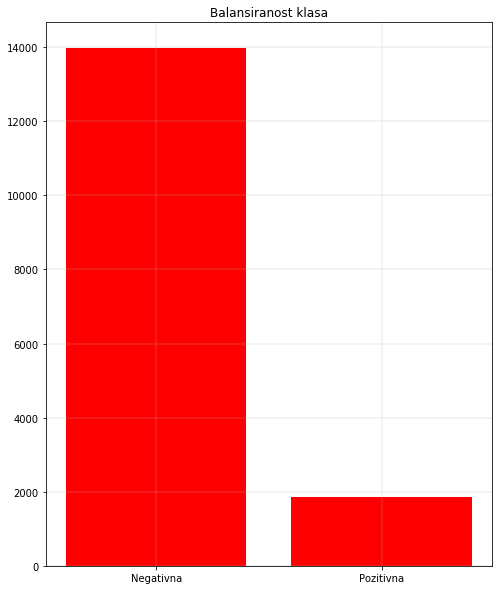

In [40]:
# Prvo da vizualizujemo u kakvom su odnosu klase

fig = plt.figure (figsize = (8, 10))
plt.title ('Balansiranost klasa')
plt.xticks (ticks = range (2), labels = ['Negativna', 'Pozitivna'])
plt.bar ([0, 1], [sum(y == 0), sum (y == 1)], color = 'red')
plt.grid (linewidth = 0.3)
plt.show()


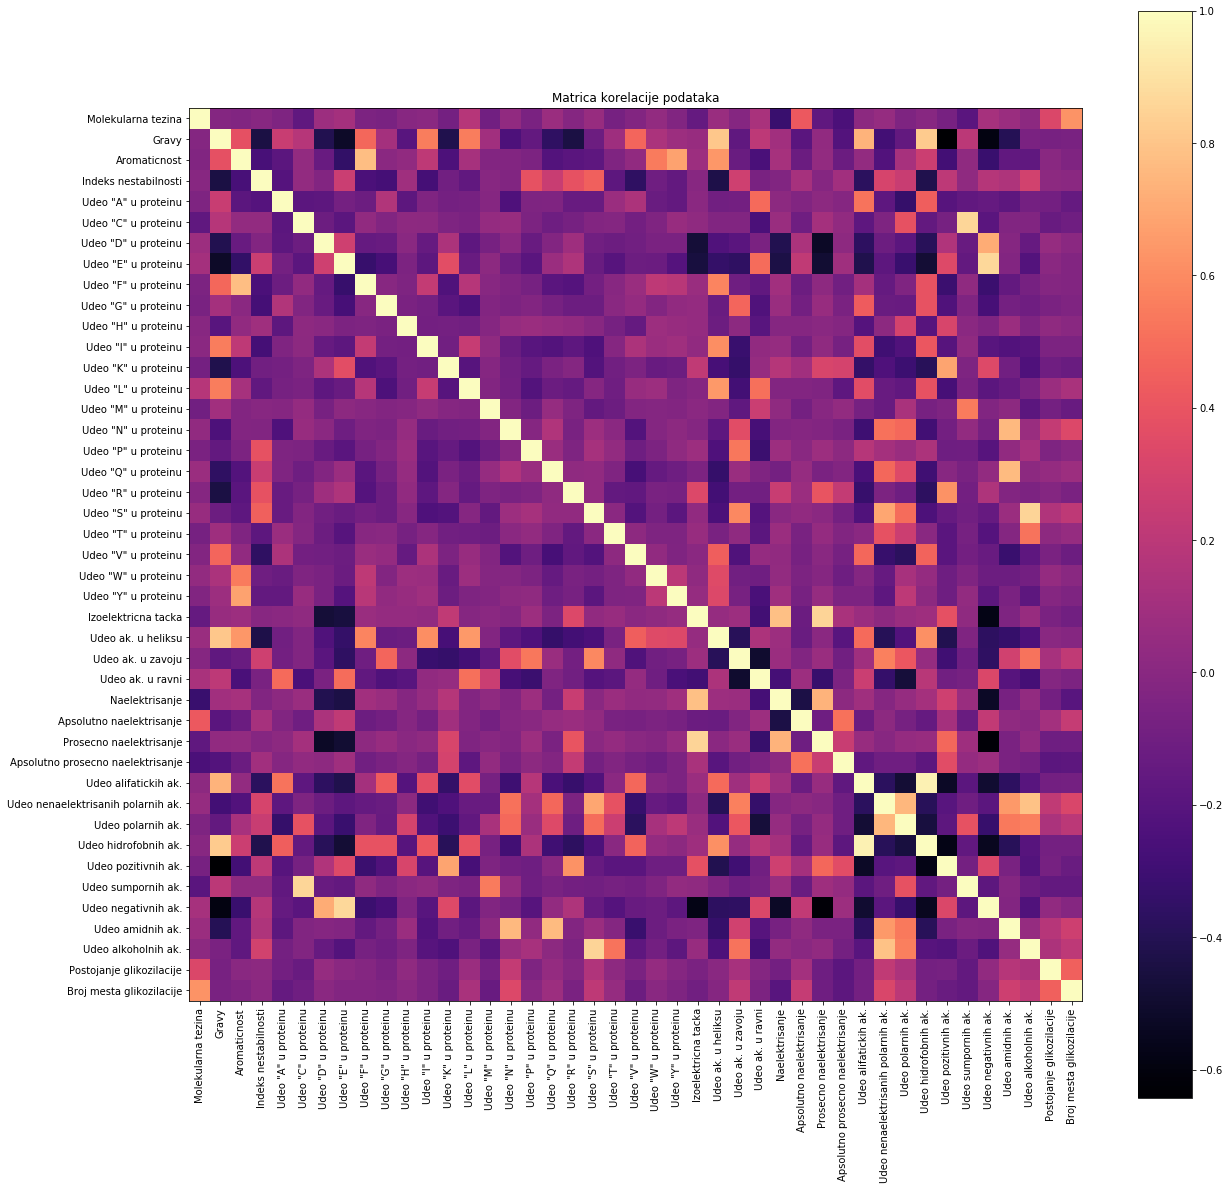

In [41]:
# Vizualizacija podataka pomocu matrice korelacije
kolone = df_sve.columns.values

fig = plt.figure (figsize = (20, 20))
plt.title ('Matrica korelacije podataka')
plt.xticks (ticks = range (len (kolone)), labels = kolone, rotation = 90)
plt.yticks (ticks = range (len (kolone)), labels = kolone)
plt.imshow (df_sve.corr(), cmap = 'magma')
plt.colorbar()
plt.show()

# Vidimo da nije velika korelisanost podataka ni u jednom delu, sto je jako dobro


# 2. Neposredna priprema podataka zarad ispravne primene modela masinskog ucenja
## 2.1 Deljenje na skupove za trening i test

Broj proteina u x_trening skupu podataka:  (7108, 43)
Broj proteina u y_trening skupu podataka:  (7108,)
Broj proteina u x_test skupu podataka:  (5227, 43)
Broj proteina u y_test skupu podataka:  (5227,)


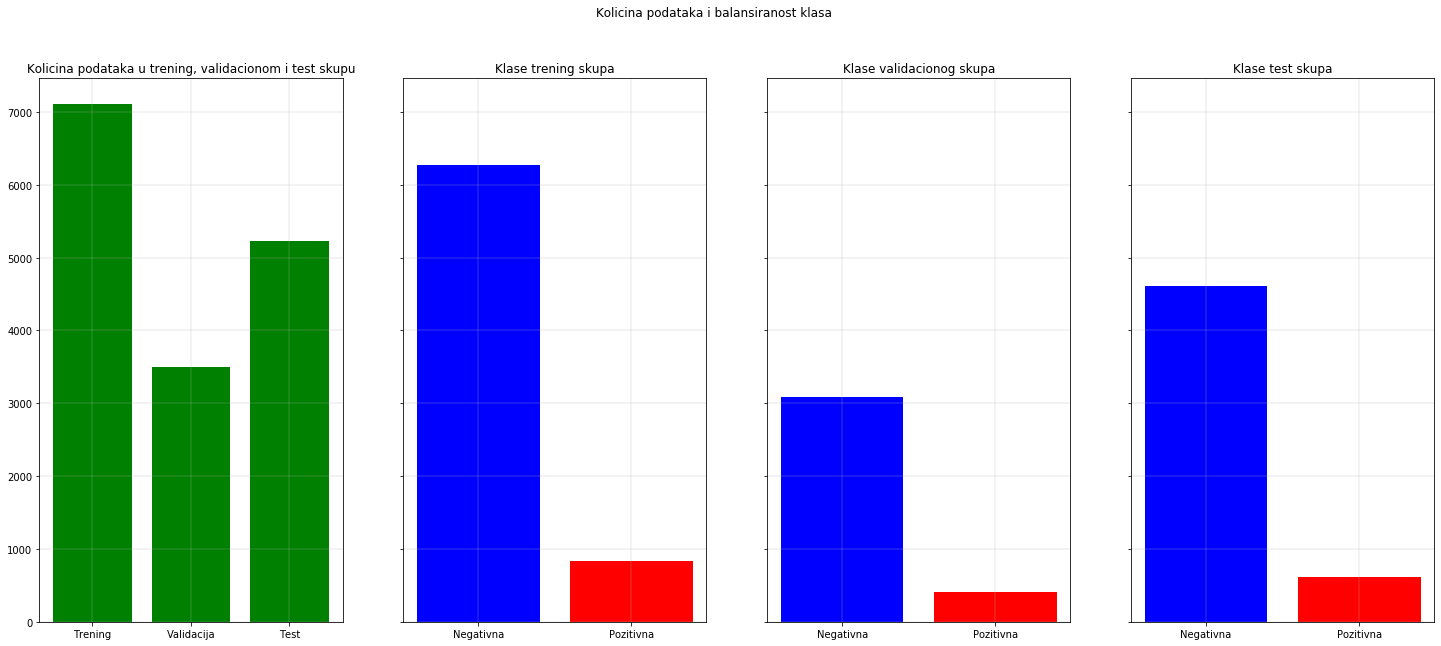

In [42]:
# Deljenje podataka na skupove za trening, validaciju i test, 2:1 odnos svuda
# Bitan parametar predstavlja i stratifikacija po klasi, tako da imamo ujednaceno deljenje na skupove (tj. balansiranost klasa po skupovima)
X = df_sve.values

x_trening_valid, x_test, y_trening_valid, y_test = ms.train_test_split (X, y, train_size = 0.67, test_size = 0.33, stratify = y, random_state = 7)
x_trening, x_valid, y_trening, y_valid = ms.train_test_split (x_trening_valid, y_trening_valid, train_size = 0.67, test_size = 0.33, stratify = y_trening_valid, random_state = 7)

# Standardizacija podataka
skaler_1 = prep.StandardScaler()
skaler_1.fit (x_trening)
x_trening = skaler_1.transform (x_trening)
x_valid = skaler_1.transform (x_valid)

skaler_2 = prep.StandardScaler()
skaler_2.fit (x_trening_valid)
x_trening_valid = skaler_2.transform (x_trening_valid)
x_test = skaler_2.transform (x_test)

print ('Broj proteina u x_trening skupu podataka: ', x_trening.shape)
print ('Broj proteina u y_trening skupu podataka: ', y_trening.shape)
print ('Broj proteina u x_test skupu podataka: ', x_test.shape)
print ('Broj proteina u y_test skupu podataka: ', y_test.shape)

# Vizualizacija podele na trening, validacioni i test skup i balansiranosti klasa

fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, sharey = True, figsize = (25, 10))
plt.suptitle ('Kolicina podataka i balansiranost klasa')

ax1.set_title ('Kolicina podataka u trening, validacionom i test skupu')
ax1.set_xticks (ticks = range (3))
ax1.set_xticklabels (labels = ['Trening', 'Validacija', 'Test'])
ax1.bar ([0, 1, 2], [x_trening.shape[0], x_valid.shape[0], x_test.shape[0]], color = 'green')
ax1.grid (linewidth = 0.3)

ax2.set_title ('Klase trening skupa')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y_trening == 0), sum (y_trening == 1)], color = ['blue', 'red'])
ax2.grid (linewidth = 0.3)

ax3.set_title ('Klase validacionog skupa')
ax3.set_xticks (ticks = range (2))
ax3.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax3.bar ([0, 1], [sum(y_valid == 0), sum (y_valid == 1)], color = ['blue', 'red'])
ax3.grid (linewidth = 0.3)

ax4.set_title ('Klase test skupa')
ax4.set_xticks (ticks = range (2))
ax4.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax4.bar ([0, 1], [sum(y_test == 0), sum (y_test == 1)], color = ['blue', 'red'])
ax4.grid (linewidth = 0.3)

plt.show()


## 2.2 Balansiranje podataka nasumicnim podsempliranjem (pomocu _imblearn_ biblioteke)

In [43]:
# Balansiranje podataka podsempliranjem (nasumicnim podsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)
# Prvo balansiram deo koji ce se koristiti za ucenje, tj. samo trening skup

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

pod_sempler_1 = RandomUnderSampler(random_state = 7)
x_trening_pod, y_trening_pod = pod_sempler_1.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon podsempliranja:', x_trening_pod.shape)
print ('Izgled y_trening skupa nakon podsempliranja:', y_trening_pod.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_pod == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_pod == 0))

# Balansiranje dela za evaluaciju mreze, tj. trening_valid skupa

print ('\nBroj pozitivnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 1))
print ('Broj negativnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 0))

pod_sempler_2 = RandomUnderSampler(random_state = 7)
x_trening_valid_pod, y_trening_valid_pod = pod_sempler_2.fit_sample (x_trening_valid, y_trening_valid)

print ('Izgled x_trening_valid skupa nakon podsempliranja:', x_trening_valid_pod.shape)
print ('Izgled y_trening_valid skupa nakon podsempliranja:', y_trening_valid_pod.shape)

print ('Broj pozitivnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_pod == 1))
print ('Broj negativnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_pod == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  836
Broj negativnih proteina trening skupa, pre balansiranja:  6272
Izgled x_trening skupa nakon podsempliranja: (1672, 43)
Izgled y_trening skupa nakon podsempliranja: (1672,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  836
Broj negativnih proteina trening skupa, nakon balansiranja:  836

Broj pozitivnih proteina trening_valid skupa, pre balansiranja:  1248
Broj negativnih proteina trening_valid skupa, pre balansiranja:  9362
Izgled x_trening_valid skupa nakon podsempliranja: (2496, 43)
Izgled y_trening_valid skupa nakon podsempliranja: (2496,)
Broj pozitivnih proteina trening_valid skupa, nakon balansiranja:  1248
Broj negativnih proteina trening_valid skupa, nakon balansiranja:  1248


## 2.3 Balansiranje podataka nadsempliranjem SMOTE algoritmom

In [44]:
# Balansiranje podataka nadsempliranjem (SMOTE algoritmom, a ne nasumicnim nadsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)
# Izabran je SMOTE algoritam jer je on koristi algoritam K najblizih suseda za generisanje novih podataka, samim tim daje relevantnije nove informacije
# Prvo balansiram deo koji ce se koristiti za ucenje, tj. samo trening skup

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

nad_sempler_smote_1 = SMOTE(random_state = 7, n_jobs = -1)
x_trening_nad_smote, y_trening_nad_smote = nad_sempler_smote_1.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon nadsempliranja:', x_trening_nad_smote.shape)
print ('Izgled y_trening skupa nakon nadsempliranja:', y_trening_nad_smote.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_smote == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_smote == 0))

# Balansiranje dela za evaluaciju mreze, tj. trening_valid skupa

print ('\nBroj pozitivnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 1))
print ('Broj negativnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 0))

nad_sempler_smote_2 = SMOTE(random_state = 7, n_jobs = -1)
x_trening_valid_nad_smote, y_trening_valid_nad_smote = nad_sempler_smote_2.fit_sample (x_trening_valid, y_trening_valid)

print ('Izgled x_trening_valid skupa nakon nadsempliranja:', x_trening_valid_nad_smote.shape)
print ('Izgled y_trening_valid skupa nakon nadsempliranja:', y_trening_valid_nad_smote.shape)

print ('Broj pozitivnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_nad_smote == 1))
print ('Broj negativnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_nad_smote == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  836
Broj negativnih proteina trening skupa, pre balansiranja:  6272
Izgled x_trening skupa nakon nadsempliranja: (12544, 43)
Izgled y_trening skupa nakon nadsempliranja: (12544,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  6272
Broj negativnih proteina trening skupa, nakon balansiranja:  6272

Broj pozitivnih proteina trening_valid skupa, pre balansiranja:  1248
Broj negativnih proteina trening_valid skupa, pre balansiranja:  9362
Izgled x_trening_valid skupa nakon nadsempliranja: (18724, 43)
Izgled y_trening_valid skupa nakon nadsempliranja: (18724,)
Broj pozitivnih proteina trening_valid skupa, nakon balansiranja:  9362
Broj negativnih proteina trening_valid skupa, nakon balansiranja:  9362


## 2.4 Balansiranje podataka nadsempliranjem ADASYN algoritmom

In [45]:
# Balansiranje podataka nadsempliranjem (ADASYN algoritmom, a ne nasumicnim nadsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)
# ADASYN predstavlja poboljsanje SMOTE algoritma koji kreira 'realnije' podatke
# Prvo balansiram deo koji ce se koristiti za ucenje, tj. samo trening skup

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

nad_sempler_adasyn_1 = ADASYN(random_state = 7, n_jobs = -1)
x_trening_nad_adasyn, y_trening_nad_adasyn = nad_sempler_adasyn_1.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon nadsempliranja:', x_trening_nad_adasyn.shape)
print ('Izgled y_trening skupa nakon nadsempliranja:', y_trening_nad_adasyn.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_adasyn == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_adasyn == 0))

# Balansiranje dela za evaluaciju mreze, tj. trening_valid skupa

print ('\nBroj pozitivnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 1))
print ('Broj negativnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 0))

nad_sempler_adasyn_2 = ADASYN(random_state = 7, n_jobs = -1)
x_trening_valid_nad_adasyn, y_trening_valid_nad_adasyn = nad_sempler_adasyn_2.fit_sample (x_trening_valid, y_trening_valid)

print ('Izgled x_trening_valid skupa nakon nadsempliranja:', x_trening_valid_nad_adasyn.shape)
print ('Izgled y_trening_valid skupa nakon nadsempliranja:', y_trening_valid_nad_adasyn.shape)

print ('Broj pozitivnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_nad_adasyn == 1))
print ('Broj negativnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_nad_adasyn == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  836
Broj negativnih proteina trening skupa, pre balansiranja:  6272
Izgled x_trening skupa nakon nadsempliranja: (12669, 43)
Izgled y_trening skupa nakon nadsempliranja: (12669,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  6397
Broj negativnih proteina trening skupa, nakon balansiranja:  6272

Broj pozitivnih proteina trening_valid skupa, pre balansiranja:  1248
Broj negativnih proteina trening_valid skupa, pre balansiranja:  9362
Izgled x_trening_valid skupa nakon nadsempliranja: (18778, 43)
Izgled y_trening_valid skupa nakon nadsempliranja: (18778,)
Broj pozitivnih proteina trening_valid skupa, nakon balansiranja:  9416
Broj negativnih proteina trening_valid skupa, nakon balansiranja:  9362


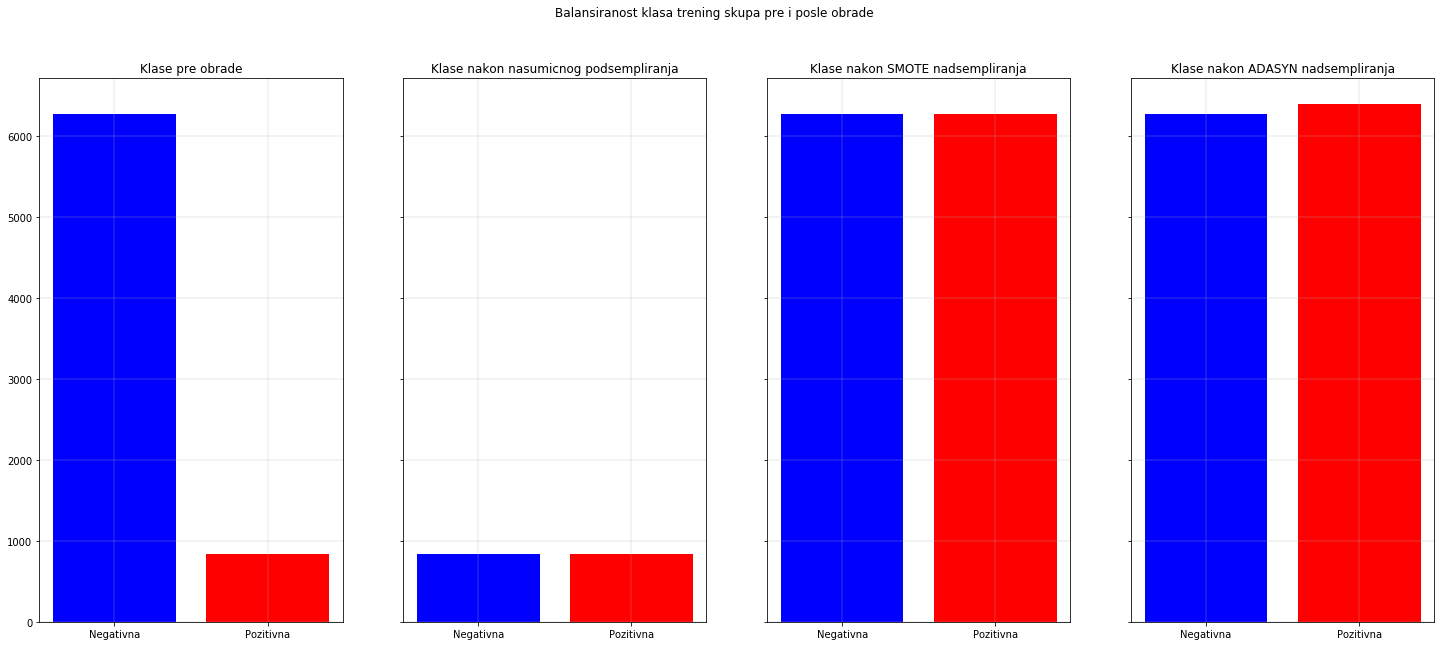

In [46]:
# Vizualizacija polaznih podataka trening i trening_valid skupa, zatim podataka nakon podsempliranja i nakon nadsempliranja

fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, sharey = True, figsize = (25, 10))
plt.suptitle ('Balansiranost klasa trening skupa pre i posle obrade')

ax1.set_title ('Klase pre obrade')
ax1.set_xticks (ticks = range (2))
ax1.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax1.bar ([0, 1], [sum(y_trening == 0), sum (y_trening == 1)], color = ['blue', 'red'])
ax1.grid (linewidth = 0.3)

ax2.set_title ('Klase nakon nasumicnog podsempliranja')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y_trening_pod == 0), sum (y_trening_pod == 1)], color = ['blue', 'red'])
ax2.grid (linewidth = 0.3)

ax3.set_title ('Klase nakon SMOTE nadsempliranja')
ax3.set_xticks (ticks = range (2))
ax3.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax3.bar ([0, 1], [sum(y_trening_nad_smote == 0), sum (y_trening_nad_smote == 1)], color = ['blue', 'red'])
ax3.grid (linewidth = 0.3)

ax4.set_title ('Klase nakon ADASYN nadsempliranja')
ax4.set_xticks (ticks = range (2))
ax4.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax4.bar ([0, 1], [sum(y_trening_nad_adasyn == 0), sum (y_trening_nad_adasyn == 1)], color = ['blue', 'red'])
ax4.grid (linewidth = 0.3)

plt.show()


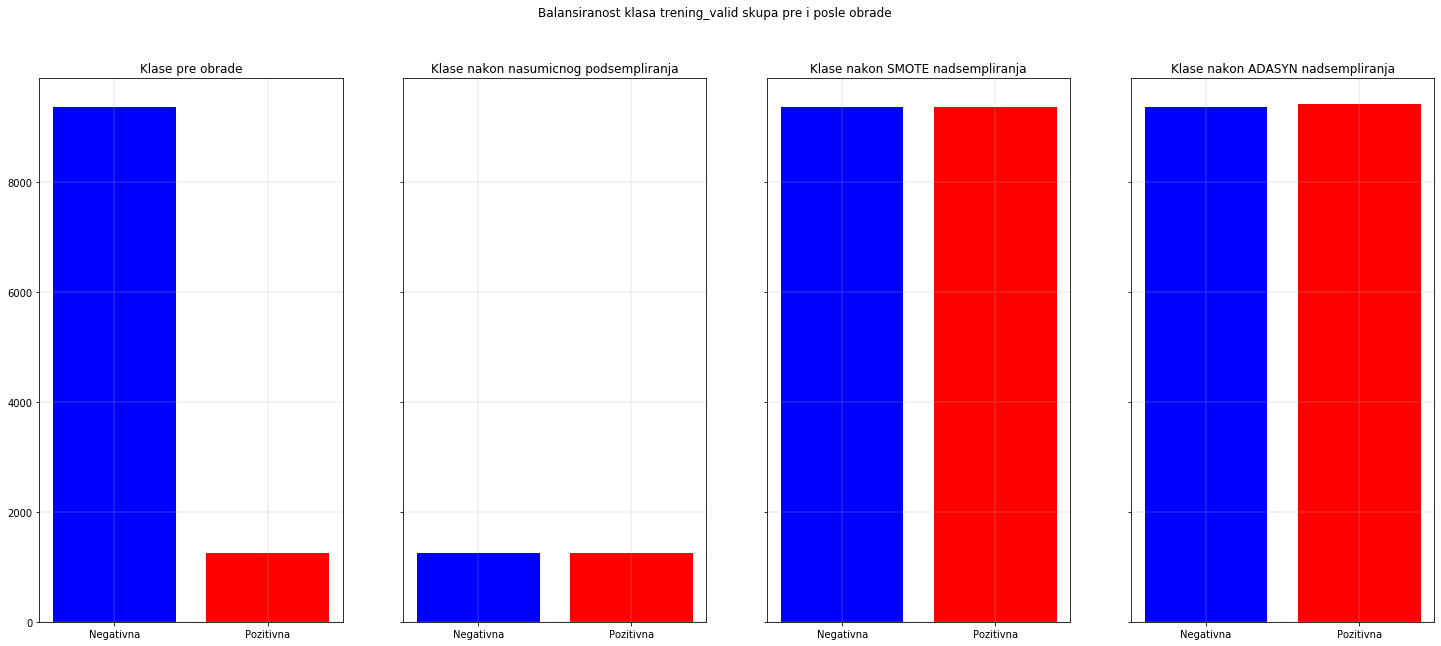

In [47]:
# Sad validacioni

fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, sharey = True, figsize = (25, 10))
plt.suptitle ('Balansiranost klasa trening_valid skupa pre i posle obrade')

ax1.set_title ('Klase pre obrade')
ax1.set_xticks (ticks = range (2))
ax1.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax1.bar ([0, 1], [sum(y_trening_valid == 0), sum (y_trening_valid == 1)], color = ['blue', 'red'])
ax1.grid (linewidth = 0.3)

ax2.set_title ('Klase nakon nasumicnog podsempliranja')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y_trening_valid_pod == 0), sum (y_trening_valid_pod == 1)], color = ['blue', 'red'])
ax2.grid (linewidth = 0.3)

ax3.set_title ('Klase nakon SMOTE nadsempliranja')
ax3.set_xticks (ticks = range (2))
ax3.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax3.bar ([0, 1], [sum(y_trening_valid_nad_smote == 0), sum (y_trening_valid_nad_smote == 1)], color = ['blue', 'red'])
ax3.grid (linewidth = 0.3)

ax4.set_title ('Klase nakon ADASYN nadsempliranja')
ax4.set_xticks (ticks = range (2))
ax4.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax4.bar ([0, 1], [sum(y_trening_valid_nad_adasyn == 0), sum (y_trening_valid_nad_adasyn == 1)], color = ['blue', 'red'])
ax4.grid (linewidth = 0.3)

plt.show()


In [0]:
# Funkcija za lepo iscrtavanje matrice konfuzije
# Preuzeta i modifikovana za potrebe rada sa zvanicnog sajta biblioteke SciKit-Learn:
# https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html
def nacrtaj_matricu_konfuzije (y_test, y_procena, ime_modela):
    
    #plt.style.use ('dark_background')
    mat_konf = met.confusion_matrix(y_test, y_procena)
    
    # Kreiranje normalizovane verzije matrice konfuzije
    norm_mat_konf = mat_konf.astype('float') / mat_konf.sum(axis=1)[:, np.newaxis]
    
    klase = np.unique (np.hstack ((y_test, y_procena)))
    
    # Kreiranje grafika za svaku od matrica
    fig, (ax_1, ax_2) = plt.subplots (1, 2, figsize = (20, 10))
    plt.suptitle ('Matrice konfuzije za model: ' + ime_modela)
    
    slika_1 = ax_1.imshow (mat_konf, interpolation = 'nearest', cmap = 'Reds')
    ax_1.figure.colorbar (slika_1, ax = ax_1, shrink = 0.8)
    
    slika_2 = ax_2.imshow (norm_mat_konf, interpolation = 'nearest', cmap = 'Reds')
    ax_2.figure.colorbar (slika_2, ax = ax_2, shrink = 0.8)
    
    ax_1.set (xticks = np.arange (mat_konf.shape[1]),
              yticks = np.arange (mat_konf.shape[0]),
              xticklabels = klase,
              yticklabels = klase,
              title = 'Matrica konfuzije bez normalizacije',
              ylabel = 'Stvarne vrednosti',
              xlabel = 'Procenjene vrednosti')
    
    ax_2.set (xticks = np.arange (norm_mat_konf.shape[1]),
              yticks = np.arange (norm_mat_konf.shape[0]),
              xticklabels = klase,
              yticklabels = klase,
              title = 'Normalizovana matrica konfuzije',
              ylabel = 'Stvarne vrednosti',
              xlabel = 'Procenjene vrednosti')
    
    # Potrebno zbog baga u trenutnoj verziji Matplotlib-a 3.1.1, izbrisati nakon nadogradnje
    # Bag: https://github.com/matplotlib/matplotlib/issues/15154
    ################################################################
    ax_1.set_ylim (mat_konf.shape[0] - 0.5, -0.5)
    ax_2.set_ylim (norm_mat_konf.shape[0] - 0.5, -0.5)
    ################################################################
    
    plt.setp (ax_1.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    plt.setp (ax_2.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    
    tekst = [['Stvarno negativni\n','Lazno pozitivni\n'], ['Lazno negativni\n', 'Stvarno pozitivni\n']]
    
    for i in range (mat_konf.shape[0]):
        for j in range(mat_konf.shape[1]):
            ax_1.text (j, i, str (tekst[i][j]) + format(mat_konf[i, j], 'g'), horizontalalignment = 'center', verticalalignment = 'center', bbox = dict (facecolor = 'gray', alpha = 0.9))
            ax_2.text (j, i, str (tekst[i][j]) + format(norm_mat_konf[i, j], 'g'), horizontalalignment = 'center', verticalalignment = 'center', bbox = dict (facecolor = 'gray', alpha = 0.9))
    
    fig.tight_layout()
    
    return ax_1, ax_2

# Funkcija za iscrtavanje grafika ucenja mreze (tacnost i greska) nad razlicitim skupovima
def nacrtaj_ucenje (istorija, ime_modela):
    
    tacnost = istorija.history ['binary_accuracy']
    val_tacnost = istorija.history ['val_binary_accuracy']
    greska = istorija.history ['loss']
    val_greska = istorija.history ['val_loss']
    
    fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (20, 10))
    plt.suptitle ('Grafici tacnosti i greske za model: ' + ime_modela)
    
    ax1.set_title ('Grafik tacnosti modela u zavisnosti od epohe')
    ax1.set_xlabel ('Epoha')
    ax1.set_ylabel ('Binarna Tacnost')
    ax1.plot (istorija.epoch, tacnost, c = 'r', label = 'Trening')
    ax1.plot (istorija.epoch, val_tacnost, c = 'g', label = 'Validacija')
    ax1.grid (linewidth = 0.3)
    ax1.legend()
    
    ax2.set_title ('Grafik greske modela u zavisnosti od epohe')
    ax2.set_xlabel ('Epoha')
    ax2.set_ylabel ('Greska')
    ax2.plot (istorija.epoch, greska, c = 'r', label = 'Trening')
    ax2.plot (istorija.epoch, val_greska, c = 'g', label = 'Validacija')
    ax2.grid (linewidth = 0.3)
    ax2.legend()
    
    plt.show()


# 3. Primena potpuno povezane neuronske mreze nad razlicito balansiranim skpovima podataka

## 3.1 Polazni skup podataka nad kojim nisu primenjene tehnike balansiranja

### 3.1.1 Potpuno povezana neuronska mreza bez ukljucenog class_weight parametra (koji uzima u obzir nebalansiranost klasa pri ucenju)


In [0]:
# Definisanje parametara svih mreza
dim_ulaza = len (kolone)
dim_izlaza = 1

#########################################################################################################
# Vrednosti koje sam prvobitno koristio

# inicijalizatori = ['uniform', 'normal', 'lecun_normal', 'lecun_uniform', 'he_normal', 'he_uniform', 'glorot_normal', 'glorot_uniform']
# optimizatori = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# vel_grupa = [32, 64]
#########################################################################################################

# Nove vrednosti, nakon odluke da se varira arhitektura

inicijalizatori = ['he_normal', 'he_uniform', 'glorot_normal', 'glorot_uniform']
optimizatori = ['RMSprop', 'Nadam']
vel_grupa = [32]
br_neurona_1 = [30, 25, 20] # Za potencijalni prvi skriveni sloj
br_neurona_2 = [18, 15, 13] # Za potencijalni drugi skriveni sloj
br_neurona_3 = [10, 8, 5] # Za potencijalni treci skriveni sloj

kolbekovi = [EarlyStopping (monitor = 'val_loss', patience = 13, restore_best_weights = True)]

epohe = 200


In [0]:
# Sa jednim skrivenim slojem
def napravi_mrezu_1 (optimizer, kernel_initializer, br_neur_1):
	
    K.clear_session()
    mreza = Sequential()
    mreza.add (Dense (units = br_neur_1, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = dim_izlaza))
    mreza.add (BatchNormalization())
    mreza.add (Activation('sigmoid'))

    mreza.compile (optimizer = optimizer, loss = losses.binary_crossentropy, metrics = [ker_met.binary_accuracy
])
    
    return mreza

# Sa dva skrivena sloja
def napravi_mrezu_2 (optimizer, kernel_initializer, br_neur_1, br_neur_2):
	
    K.clear_session()
    mreza = Sequential()
    mreza.add (Dense (units = br_neur_1, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = br_neur_2, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = dim_izlaza))
    mreza.add (BatchNormalization())
    mreza.add (Activation('sigmoid'))

    mreza.compile (optimizer = optimizer, loss = losses.binary_crossentropy, metrics = [ker_met.binary_accuracy])
    
    return mreza

# Sa tri skrivena sloja
def napravi_mrezu_3 (optimizer, kernel_initializer, br_neur_1, br_neur_2, br_neur_3):
	
    K.clear_session()
    mreza = Sequential()
    mreza.add (Dense (units = br_neur_1, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = br_neur_2, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = br_neur_3, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = dim_izlaza))
    mreza.add (BatchNormalization())
    mreza.add (Activation('sigmoid'))

    mreza.compile (optimizer = optimizer, loss = losses.binary_crossentropy, metrics = [ker_met.binary_accuracy])
    
    return mreza
  

In [0]:
def nadji_najbolje_parametre (X_TREN, Y_TREN, X_VAL, Y_VAL, X_TEST, Y_TEST, BR_SLOJA, TEZINA_KLASA = None):
  
  najb_f1 = 0
  i = 0
  poc_vreme = timer()
  
  if BR_SLOJA == 1:
    
    najb_par = {'opt' : '', 'kern_ini' : '', 'batch_size' : 0, 'br_n_1' : 0}
    ukupno_prolaza = len(br_neurona_1) * len(optimizatori) * len(inicijalizatori) * len(vel_grupa)
    print ('Ukupan broj prolaza:', ukupno_prolaza)
    
    for br_n_1 in br_neurona_1:
      for op in optimizatori:
        for inic in inicijalizatori:
          for v_g in vel_grupa:

            mreza = napravi_mrezu_1 (optimizer = op, kernel_initializer = inic, br_neur_1 = br_n_1)
            mreza.fit (X_TREN, Y_TREN, validation_data = (X_VAL, Y_VAL), epochs = epohe, batch_size = v_g, callbacks = kolbekovi, class_weight = TEZINA_KLASA, verbose = 0)

            y_procena = mreza.predict(X_TEST)
            y_procena_zaok = np.rint (y_procena)
            izvestaj = met.classification_report (Y_TEST, y_procena_zaok, output_dict = True)

            if izvestaj['1']['f1-score'] > najb_f1:
              najb_f1 = izvestaj['1']['f1-score']
              najb_par['opt'] = op
              najb_par['kern_ini'] = inic
              najb_par['batch_size'] = v_g
              najb_par['br_n_1'] = br_n_1
              print ('Novi f1 skor:', najb_f1)
            
            i += 1
            if (ukupno_prolaza // 4 == i) or (ukupno_prolaza // 2 == i) or (3 * ukupno_prolaza // 4 == i):
              print ('Prolaz:', i)

  elif BR_SLOJA == 2:
    
    najb_par = {'opt' : '', 'kern_ini' : '', 'batch_size' : 0, 'br_n_1' : 0, 'br_n_2' : 0}
    ukupno_prolaza = len(br_neurona_1) * len(br_neurona_2) * len(optimizatori) * len(inicijalizatori) * len(vel_grupa)
    print ('Ukupan broj prolaza:', ukupno_prolaza)
    
    for br_n_1 in br_neurona_1:
      for br_n_2 in br_neurona_2:
        for op in optimizatori:
          for inic in inicijalizatori:
            for v_g in vel_grupa:
              
              mreza = napravi_mrezu_2 (optimizer = op, kernel_initializer = inic, br_neur_1 = br_n_1, br_neur_2 = br_n_2)
              mreza.fit (X_TREN, Y_TREN, validation_data = (X_VAL, Y_VAL), epochs = epohe, batch_size = v_g, callbacks = kolbekovi, class_weight = TEZINA_KLASA, verbose = 0)

              y_procena = mreza.predict(X_TEST)
              y_procena_zaok = np.rint (y_procena)
              izvestaj = met.classification_report (Y_TEST, y_procena_zaok, output_dict = True)

              if izvestaj['1']['f1-score'] > najb_f1:
                najb_f1 = izvestaj['1']['f1-score']
                najb_par['opt'] = op
                najb_par['kern_ini'] = inic
                najb_par['batch_size'] = v_g
                najb_par['br_n_1'] = br_n_1
                najb_par['br_n_2'] = br_n_2
                print ('Novi f1 skor:', najb_f1)

              i += 1
              if (ukupno_prolaza // 4 == i) or (ukupno_prolaza // 2 == i) or (3 * ukupno_prolaza // 4 == i):
                print ('Prolaz:', i)
  
  else:
    
    najb_par = {'opt' : '', 'kern_ini' : '', 'batch_size' : 0, 'br_n_1' : 0, 'br_n_2' : 0, 'br_n_3' : 0}
    ukupno_prolaza = len(br_neurona_1) * len(br_neurona_2) * len(br_neurona_3) * len(optimizatori) * len(inicijalizatori) * len(vel_grupa)
    print ('Ukupan broj prolaza:', ukupno_prolaza)
    
    for br_n_1 in br_neurona_1:
      for br_n_2 in br_neurona_2:
        for br_n_3 in br_neurona_3:
          for op in optimizatori:
            for inic in inicijalizatori:
              for v_g in vel_grupa:

                mreza = napravi_mrezu_3 (optimizer = op, kernel_initializer = inic, br_neur_1 = br_n_1, br_neur_2 = br_n_2, br_neur_3 = br_n_3)
                mreza.fit (X_TREN, Y_TREN, validation_data = (X_VAL, Y_VAL), epochs = epohe, batch_size = v_g, callbacks = kolbekovi, class_weight = TEZINA_KLASA, verbose = 0)

                y_procena = mreza.predict(X_TEST)
                y_procena_zaok = np.rint (y_procena)
                izvestaj = met.classification_report (Y_TEST, y_procena_zaok, output_dict = True)

                if izvestaj['1']['f1-score'] > najb_f1:
                  najb_f1 = izvestaj['1']['f1-score']
                  najb_par['opt'] = op
                  najb_par['kern_ini'] = inic
                  najb_par['batch_size'] = v_g
                  najb_par['br_n_1'] = br_n_1
                  najb_par['br_n_2'] = br_n_2
                  najb_par['br_n_3'] = br_n_3
                  print ('Novi f1 skor:', najb_f1)

                i += 1
                if (ukupno_prolaza // 4 == i) or (ukupno_prolaza // 2 == i) or (3 * ukupno_prolaza // 4 == i):
                  print ('Prolaz:', i)
  
  kraj_vreme = timer()
  print ('Proteklo vreme:', timedelta(seconds = kraj_vreme - poc_vreme))
  
  print ('Najbolji parametri:\n', najb_par)
  return najb_par


In [52]:
# Treniranje mreze sa jednim skrivenim slojem
# Vreme izvrsavanja ~ 50 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 1)


Ukupan broj prolaza: 24
Novi f1 skor: 0.6559546313799622
Novi f1 skor: 0.6603595080416272
Novi f1 skor: 0.6786389413988658
Prolaz: 6
Prolaz: 12
Prolaz: 18
Proteklo vreme: 0:49:09.434791
Najbolji parametri:
 {'opt': 'RMSprop', 'kern_ini': 'glorot_uniform', 'batch_size': 32, 'br_n_1': 30}


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [54]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nebal = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_nebal.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,475
Trainable params: 1,413
Non-trainable params: 62
___________________________________________________

In [55]:
istorija = mreza_nebal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)

Train on 7108 samples, validate on 3502 samples
Epoch 1/200
7108/7108 [==============================] - 3s 364us/step - loss: 0.6259 - binary_accuracy: 0.6967 - val_loss: 0.5073 - val_binary_accuracy: 0.8184
Epoch 2/200
7108/7108 [==============================] - 2s 295us/step - loss: 0.5104 - binary_accuracy: 0.8108 - val_loss: 0.4394 - val_binary_accuracy: 0.8775
Epoch 3/200
7108/7108 [==============================] - 2s 283us/step - loss: 0.4446 - binary_accuracy: 0.8617 - val_loss: 0.3838 - val_binary_accuracy: 0.9043
Epoch 4/200
7108/7108 [==============================] - 2s 291us/step - loss: 0.3880 - binary_accuracy: 0.8908 - val_loss: 0.3465 - val_binary_accuracy: 0.9183
Epoch 5/200
7108/7108 [==============================] - 2s 286us/step - loss: 0.3470 - binary_accuracy: 0.9031 - val_loss: 0.3092 - val_binary_accuracy: 0.9266
Epoch 6/200
7108/7108 [==============================] - 2s 265us/step - loss: 0.3117 - binary_accuracy: 0.9142 - val_loss: 0.2809 - val_binary_acc

In [56]:
y_procena = mreza_nebal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa jednim skrivenim slojem:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa jednim skrivenim slojem:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      4612
           1       0.77      0.60      0.68       615

    accuracy                           0.93      5227
   macro avg       0.86      0.79      0.82      5227
weighted avg       0.93      0.93      0.93      5227



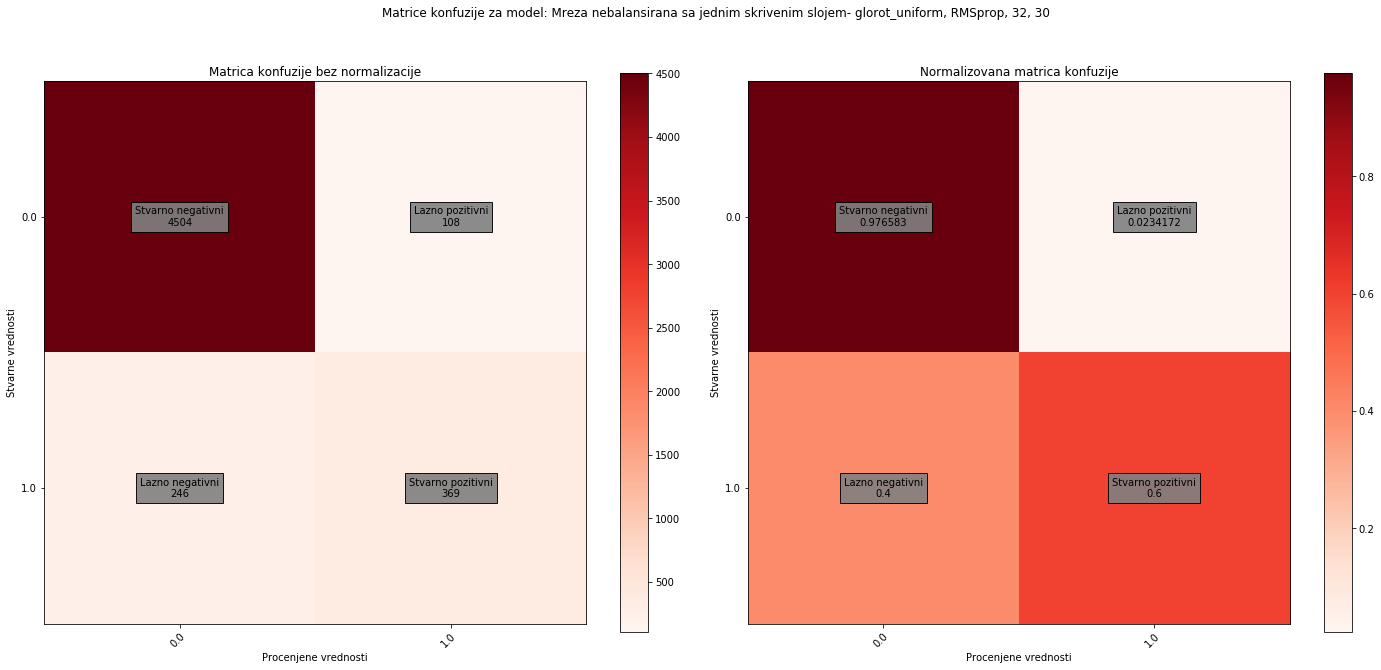

In [57]:
ime = 'Mreza nebalansirana sa jednim skrivenim slojem- ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


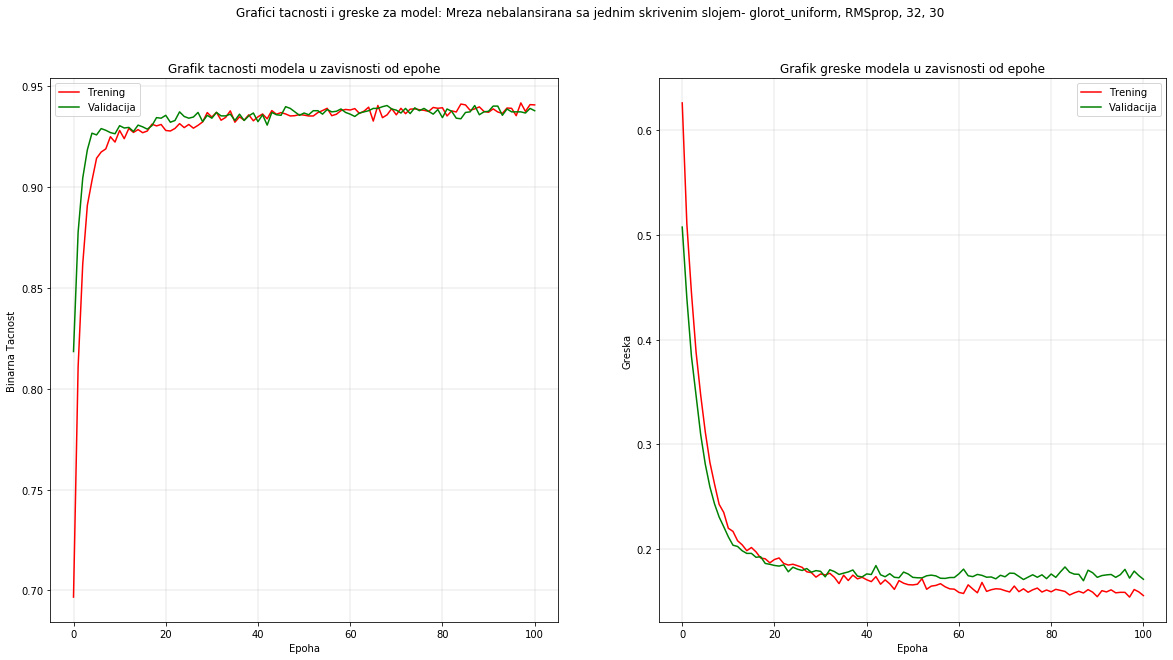

In [58]:
nacrtaj_ucenje (istorija, ime)


In [59]:
# Treniranje mreze sa dva skrivena sloja
# Vreme izvrsavanja ~ 2h 48 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 =  br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''
najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 2)


Ukupan broj prolaza: 72
Novi f1 skor: 0.6945218198700093
Novi f1 skor: 0.6976744186046512
Prolaz: 18
Prolaz: 36
Novi f1 skor: 0.7034611786716557
Prolaz: 54
Proteklo vreme: 2:48:03.224687
Najbolji parametri:
 {'opt': 'RMSprop', 'kern_ini': 'glorot_uniform', 'batch_size': 32, 'br_n_1': 25, 'br_n_2': 13}


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''
najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']

In [61]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nebal = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_nebal.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                1100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                338       
_________________________________________________________________
batch_normalization_2 (Batch (None, 13)                52        
_________________________________________________________________
activation_2 (Activation)    (None, 13)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [62]:
istorija = mreza_nebal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)

Train on 7108 samples, validate on 3502 samples
Epoch 1/200
7108/7108 [==============================] - 3s 490us/step - loss: 0.6429 - binary_accuracy: 0.6777 - val_loss: 0.5294 - val_binary_accuracy: 0.8124
Epoch 2/200
7108/7108 [==============================] - 3s 357us/step - loss: 0.4988 - binary_accuracy: 0.8354 - val_loss: 0.4353 - val_binary_accuracy: 0.8889
Epoch 3/200
7108/7108 [==============================] - 3s 366us/step - loss: 0.4290 - binary_accuracy: 0.8817 - val_loss: 0.3694 - val_binary_accuracy: 0.9143
Epoch 4/200
7108/7108 [==============================] - 3s 390us/step - loss: 0.3738 - binary_accuracy: 0.9028 - val_loss: 0.3377 - val_binary_accuracy: 0.9198
Epoch 5/200
7108/7108 [==============================] - 2s 341us/step - loss: 0.3292 - binary_accuracy: 0.9135 - val_loss: 0.2902 - val_binary_accuracy: 0.9309
Epoch 6/200
7108/7108 [==============================] - 3s 361us/step - loss: 0.2948 - binary_accuracy: 0.9192 - val_loss: 0.2651 - val_binary_acc

In [63]:
y_procena = mreza_nebal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa dva skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa dva skrivena sloja:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      4612
           1       0.80      0.59      0.68       615

    accuracy                           0.93      5227
   macro avg       0.87      0.78      0.82      5227
weighted avg       0.93      0.93      0.93      5227



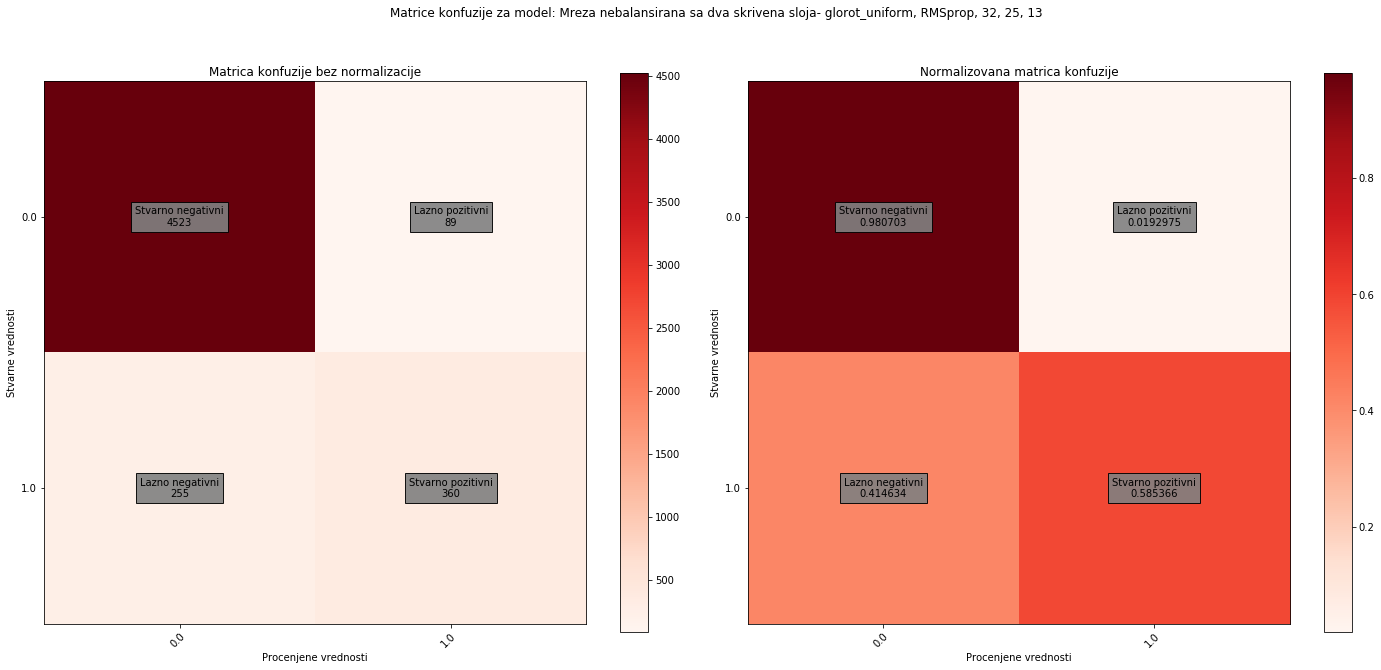

In [64]:
ime = 'Mreza nebalansirana sa dva skrivena sloja- ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


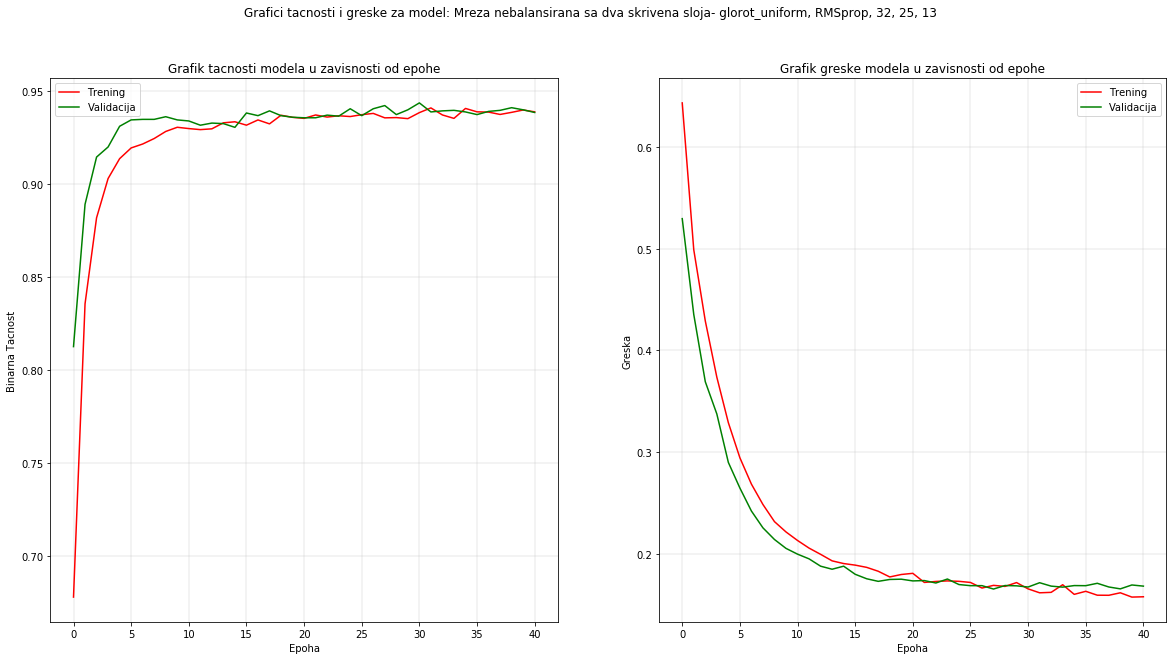

In [65]:
nacrtaj_ucenje (istorija, ime)


In [66]:
# Treniranje mreze sa tri skrivena sloja

'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 =  br_neurona_2, br_neur_3 =  br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 3)


"\nmreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)\n\nparametri = dict (br_neur_1 = br_neurona_1, br_neur_2 =  br_neurona_2, br_neur_3 =  br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)\n\nmreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)\nmreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)\n"

In [67]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

"\nnajb_opt = mreza_2.best_params_['optimizer']\nnajb_inic = mreza_2.best_params_['kernel_initializer']\nnajb_vel = mreza_2.best_params_['batch_size']\nnajb_br_neur_1 = mreza_2.best_params_['br_neur_1']\nnajb_br_neur_2 = mreza_2.best_params_['br_neur_2']\nnajb_br_neur_3 = mreza_2.best_params_['br_neur_3']\n\nprint ('Najbolji parametri mreze su:')\nprint ('Kernel initializer:', najb_inic)\nprint ('Optimizer:', najb_opt)\nprint ('Batch size:', najb_vel)\nprint ('Broj neurona prvog sloja:', najb_br_neur_1)\nprint ('Broj neurona drugog sloja:', najb_br_neur_2)\nprint ('Broj neurona treceg sloja:', najb_br_neur_3)\n\n\nnajb_opt = najb_parametri['opt']\nnajb_inic = najb_parametri['kern_ini']\nnajb_vel = najb_parametri['batch_size']\nnajb_br_neur_1 = najb_parametri['br_n_1']\nnajb_br_neur_2 = najb_parametri['br_n_2']\nnajb_br_neur_3 = najb_parametri['br_n_3']\n"

In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_nebal = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_nebal.summary()


In [0]:
#istorija = mreza_nebal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)

In [69]:
'''
y_procena = mreza_nebal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))
'''

"\ny_procena = mreza_nebal.predict(x_test)\ny_procena_zaok = np.rint (y_procena)\n\nprint ('Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))\n"

In [70]:
'''
ime = 'Mreza nebalansirana sa tri skrivena sloja- ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''

"\nime = 'Mreza nebalansirana sa tri skrivena sloja- ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))\nnacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)\nplt.show()\n"

In [0]:
#nacrtaj_ucenje (istorija, ime)


In [71]:
# Racunanje tezina klasa
# Treniranje mreze sa jednim skrivenim slojem
# Vreme izvrsavanja ~ 50 min.
tezine_klasa = cw.compute_class_weight('balanced', np.unique(y_trening_valid), y_trening_valid)
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 1, tezine_klasa)


Ukupan broj prolaza: 24
Novi f1 skor: 0.666044776119403
Novi f1 skor: 0.6772684752104771
Prolaz: 6
Prolaz: 12
Prolaz: 18
Proteklo vreme: 0:50:16.157672
Najbolji parametri:
 {'opt': 'RMSprop', 'kern_ini': 'glorot_uniform', 'batch_size': 32, 'br_n_1': 30}


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [73]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_bal = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_bal.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,475
Trainable params: 1,413
Non-trainable params: 62
___________________________________________________

In [74]:
istorija = mreza_bal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa, validation_data = (x_valid, y_valid), verbose = 1)


Train on 7108 samples, validate on 3502 samples
Epoch 1/200
7108/7108 [==============================] - 3s 373us/step - loss: 0.6360 - binary_accuracy: 0.6297 - val_loss: 0.5767 - val_binary_accuracy: 0.7196
Epoch 2/200
7108/7108 [==============================] - 2s 271us/step - loss: 0.5129 - binary_accuracy: 0.7995 - val_loss: 0.4941 - val_binary_accuracy: 0.8347
Epoch 3/200
7108/7108 [==============================] - 2s 257us/step - loss: 0.4457 - binary_accuracy: 0.8580 - val_loss: 0.4048 - val_binary_accuracy: 0.9012
Epoch 4/200
7108/7108 [==============================] - 2s 273us/step - loss: 0.3895 - binary_accuracy: 0.8890 - val_loss: 0.3500 - val_binary_accuracy: 0.9220
Epoch 5/200
7108/7108 [==============================] - 2s 260us/step - loss: 0.3472 - binary_accuracy: 0.9050 - val_loss: 0.3157 - val_binary_accuracy: 0.9292
Epoch 6/200
7108/7108 [==============================] - 2s 263us/step - loss: 0.3101 - binary_accuracy: 0.9159 - val_loss: 0.2867 - val_binary_acc

In [75]:
y_procena = mreza_bal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije balansirane potpuno povezane mreze sa jednim skrivenim slojem:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije balansirane potpuno povezane mreze sa jednim skrivenim slojem:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      4612
           1       0.79      0.56      0.66       615

    accuracy                           0.93      5227
   macro avg       0.87      0.77      0.81      5227
weighted avg       0.93      0.93      0.93      5227



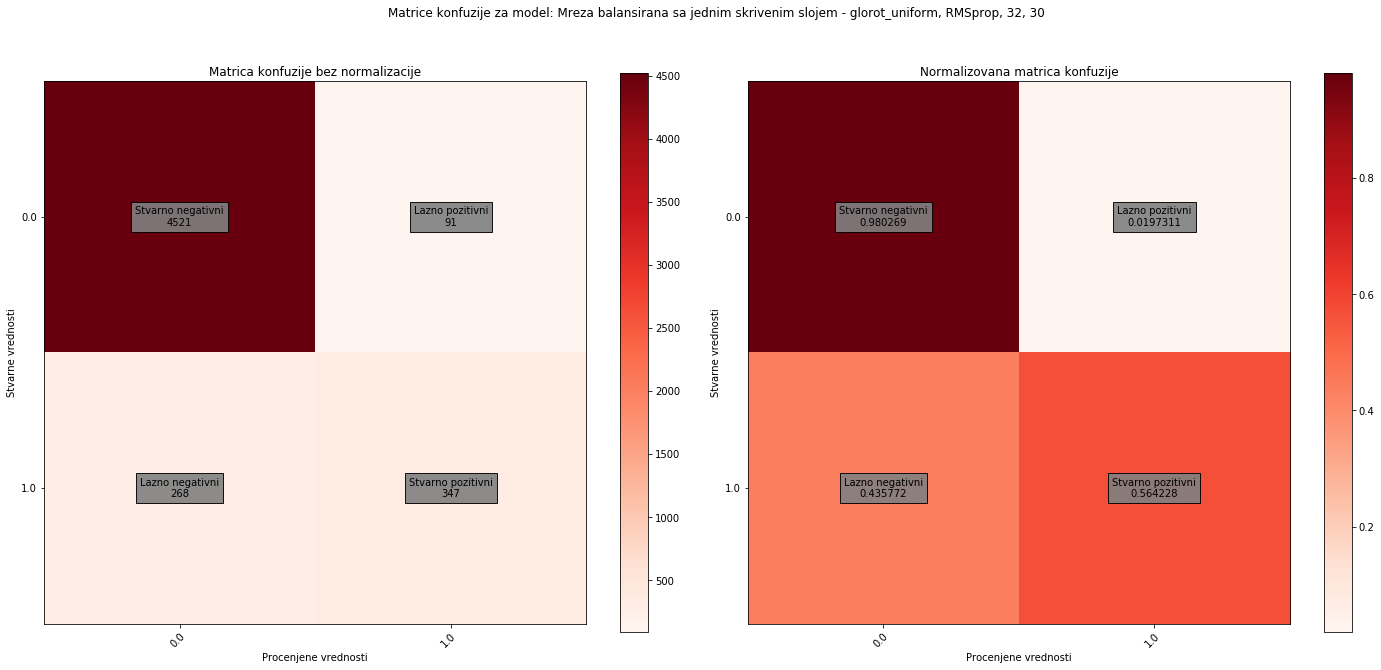

In [76]:
ime = 'Mreza balansirana sa jednim skrivenim slojem - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


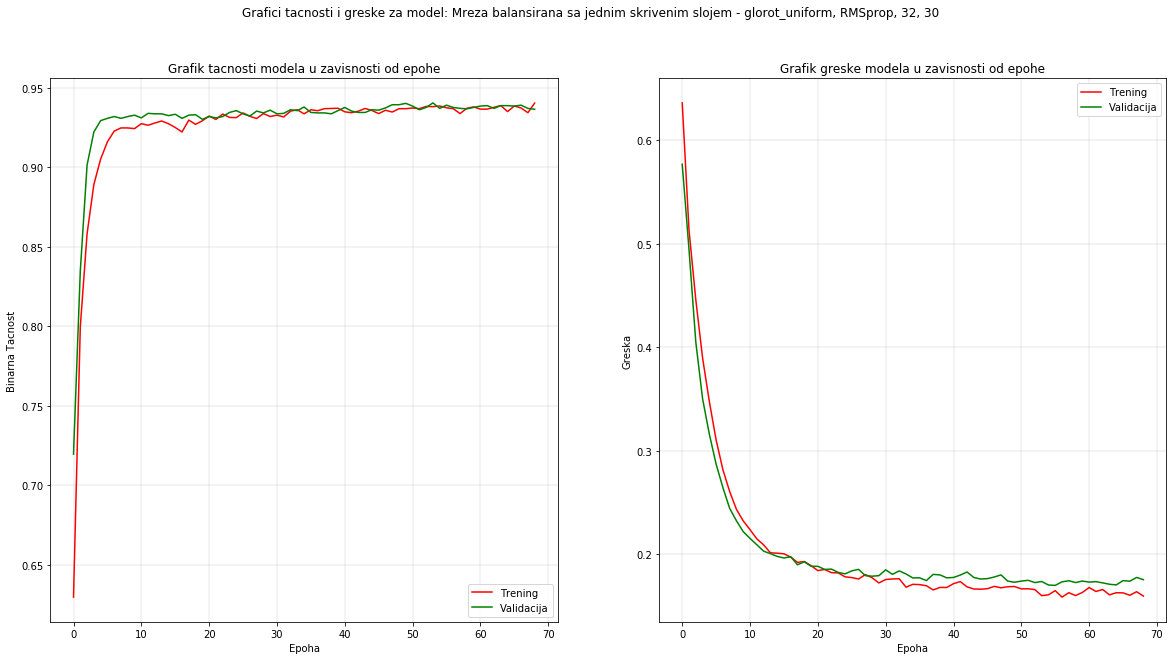

In [77]:
nacrtaj_ucenje (istorija, ime)


In [78]:
# Mreza sa dva skrivena sloja
# Vreme izvrsavanja ~ 2h 42 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 2, tezine_klasa)


Ukupan broj prolaza: 72
Novi f1 skor: 0.6788655077767612
Novi f1 skor: 0.6789328426862926
Novi f1 skor: 0.6927374301675978
Novi f1 skor: 0.697463768115942
Prolaz: 18
Novi f1 skor: 0.6979742173112339
Prolaz: 36
Prolaz: 54
Proteklo vreme: 2:41:26.942783
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'he_uniform', 'batch_size': 32, 'br_n_1': 25, 'br_n_2': 18}


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']


In [80]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_bal = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_bal.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                1100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                468       
_________________________________________________________________
batch_normalization_2 (Batch (None, 18)                72        
_________________________________________________________________
activation_2 (Activation)    (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [81]:
istorija = mreza_bal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa, validation_data = (x_valid, y_valid), verbose = 1)


Train on 7108 samples, validate on 3502 samples
Epoch 1/200
7108/7108 [==============================] - 4s 531us/step - loss: 0.5836 - binary_accuracy: 0.7364 - val_loss: 0.4913 - val_binary_accuracy: 0.8578
Epoch 2/200
7108/7108 [==============================] - 3s 412us/step - loss: 0.4317 - binary_accuracy: 0.8782 - val_loss: 0.3632 - val_binary_accuracy: 0.9163
Epoch 3/200
7108/7108 [==============================] - 3s 448us/step - loss: 0.3508 - binary_accuracy: 0.9067 - val_loss: 0.3062 - val_binary_accuracy: 0.9238
Epoch 4/200
7108/7108 [==============================] - 3s 391us/step - loss: 0.3047 - binary_accuracy: 0.9171 - val_loss: 0.2681 - val_binary_accuracy: 0.9292
Epoch 5/200
7108/7108 [==============================] - 3s 403us/step - loss: 0.2686 - binary_accuracy: 0.9209 - val_loss: 0.2410 - val_binary_accuracy: 0.9332
Epoch 6/200
7108/7108 [==============================] - 3s 387us/step - loss: 0.2492 - binary_accuracy: 0.9228 - val_loss: 0.2306 - val_binary_acc

In [82]:
y_procena = mreza_bal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije balansirane potpuno povezane mreze sa dva skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije balansirane potpuno povezane mreze sa dva skrivena sloja:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      4612
           1       0.76      0.63      0.69       615

    accuracy                           0.93      5227
   macro avg       0.85      0.80      0.83      5227
weighted avg       0.93      0.93      0.93      5227



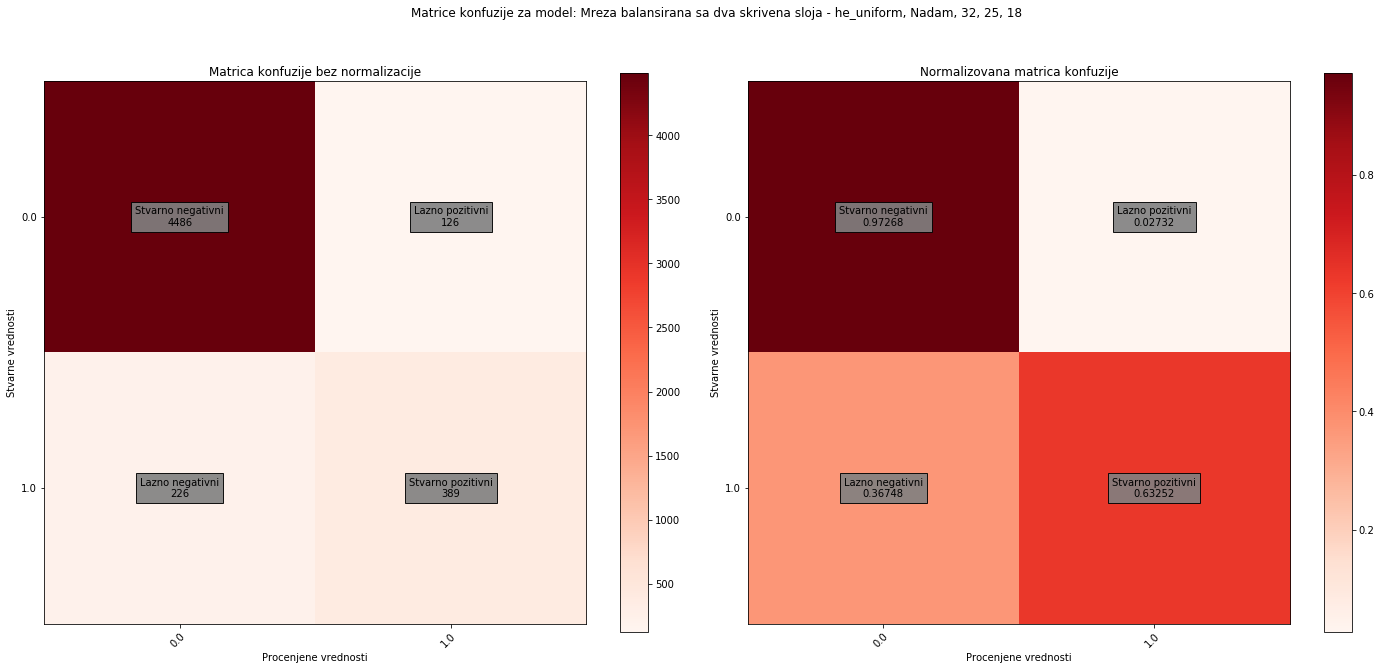

In [83]:
ime = 'Mreza balansirana sa dva skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


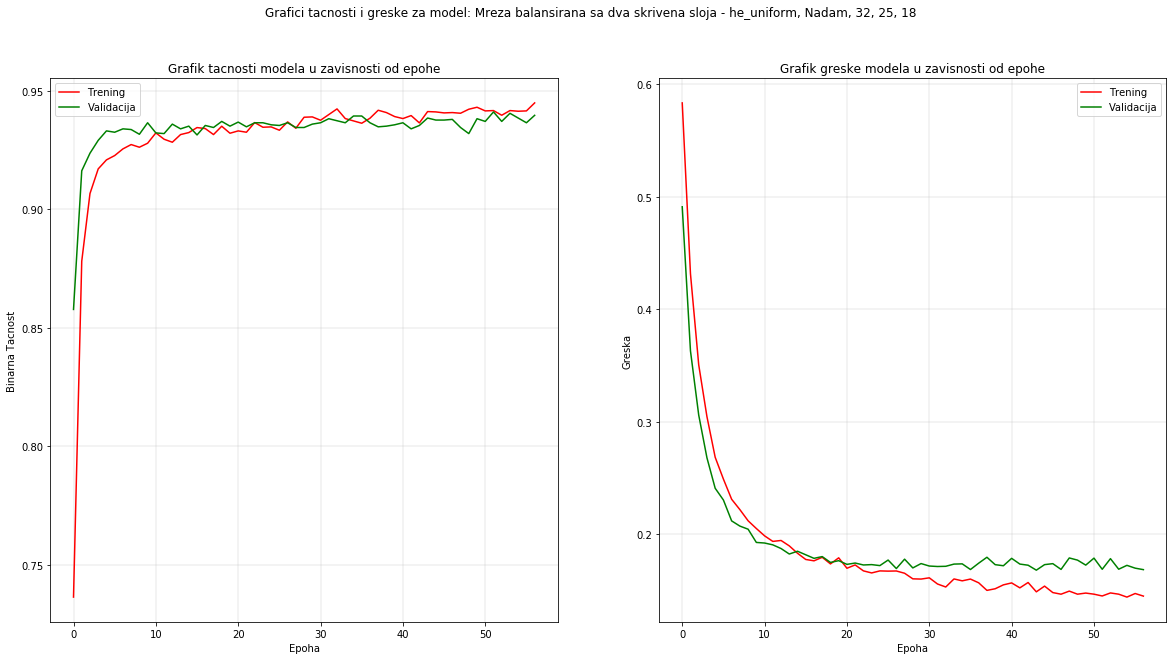

In [84]:
nacrtaj_ucenje (istorija, ime)


In [85]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~ 100 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 3, tezine_klasa)


"\nmreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)\n\nparametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)\n\nmreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)\nmreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa)\n"

In [86]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

"\nnajb_opt = mreza_2.best_params_['optimizer']\nnajb_inic = mreza_2.best_params_['kernel_initializer']\nnajb_vel = mreza_2.best_params_['batch_size']\nnajb_br_neur_1 = mreza_2.best_params_['br_neur_1']\nnajb_br_neur_2 = mreza_2.best_params_['br_neur_2']\nnajb_br_neur_3 = mreza_2.best_params_['br_neur_3']\n\nprint ('Najbolji parametri mreze su:')\nprint ('Kernel initializer:', najb_inic)\nprint ('Optimizer:', najb_opt)\nprint ('Batch size:', najb_vel)\nprint ('Broj neurona prvog sloja:', najb_br_neur_1)\nprint ('Broj neurona drugog sloja:', najb_br_neur_2)\nprint ('Broj neurona treceg sloja:', najb_br_neur_3)\n\n\nnajb_opt = najb_parametri['opt']\nnajb_inic = najb_parametri['kern_ini']\nnajb_vel = najb_parametri['batch_size']\nnajb_br_neur_1 = najb_parametri['br_n_1']\nnajb_br_neur_2 = najb_parametri['br_n_2']\nnajb_br_neur_3 = najb_parametri['br_n_3']\n"

In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_bal = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_bal.summary()


In [0]:
#istorija = mreza_bal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa, validation_data = (x_valid, y_valid), verbose = 1)


In [87]:
'''
y_procena = mreza_bal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije balansirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))
'''

"\ny_procena = mreza_bal.predict(x_test)\ny_procena_zaok = np.rint (y_procena)\n\nprint ('Izvestaj klasifikacije balansirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))\n"

In [88]:
'''
ime = 'Mreza balansirana sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''

"\nime = 'Mreza balansirana sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))\nnacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)\nplt.show()\n"

In [0]:
#nacrtaj_ucenje (istorija, ime)


## 3.2. Polazni skup podataka koji je balansiran nasumicnim podsempliranjem

In [89]:
# Ovde se obavlja GridSearch bez scoring parametra (koristi se scoring samog modela)
# To je potrebno jer je broj podataka mali te dolazi do nedefinisane f1 mere
# Vreme izvrsavanja ~ 14 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_pod, y_trening_pod, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_pod, y_trening_pod, x_valid, y_valid, x_test, y_test, 1)


Ukupan broj prolaza: 24
Novi f1 skor: 0.5581395348837209
Novi f1 skor: 0.5615176151761518
Prolaz: 6
Prolaz: 12
Novi f1 skor: 0.5643835616438356
Novi f1 skor: 0.5892547660311958
Prolaz: 18
Proteklo vreme: 0:13:19.918138
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'he_uniform', 'batch_size': 32, 'br_n_1': 25}


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [91]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_pod = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_pod.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                1100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,230
Trainable params: 1,178
Non-trainable params: 52
___________________________________________________

In [92]:
istorija = mreza_pod.fit (x_trening_pod, y_trening_pod, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 1672 samples, validate on 3502 samples
Epoch 1/200
1672/1672 [==============================] - 1s 842us/step - loss: 0.6384 - binary_accuracy: 0.6615 - val_loss: 0.5513 - val_binary_accuracy: 0.7304
Epoch 2/200
1672/1672 [==============================] - 1s 402us/step - loss: 0.5032 - binary_accuracy: 0.7841 - val_loss: 0.4948 - val_binary_accuracy: 0.7918
Epoch 3/200
1672/1672 [==============================] - 1s 410us/step - loss: 0.4703 - binary_accuracy: 0.8014 - val_loss: 0.4734 - val_binary_accuracy: 0.8104
Epoch 4/200
1672/1672 [==============================] - 1s 443us/step - loss: 0.4479 - binary_accuracy: 0.8266 - val_loss: 0.4508 - val_binary_accuracy: 0.8281
Epoch 5/200
1672/1672 [==============================] - 1s 416us/step - loss: 0.4307 - binary_accuracy: 0.8367 - val_loss: 0.4606 - val_binary_accuracy: 0.8081
Epoch 6/200
1672/1672 [==============================] - 1s 402us/step - loss: 0.4180 - binary_accuracy: 0.8337 - val_loss: 0.4323 - val_binary_acc

In [93]:
y_procena = mreza_pod.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije podsemplirane potpuno povezane sa jednim skrivenim slojem mreze:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije podsemplirane potpuno povezane sa jednim skrivenim slojem mreze:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      4612
           1       0.43      0.81      0.56       615

    accuracy                           0.85      5227
   macro avg       0.70      0.84      0.74      5227
weighted avg       0.91      0.85      0.87      5227



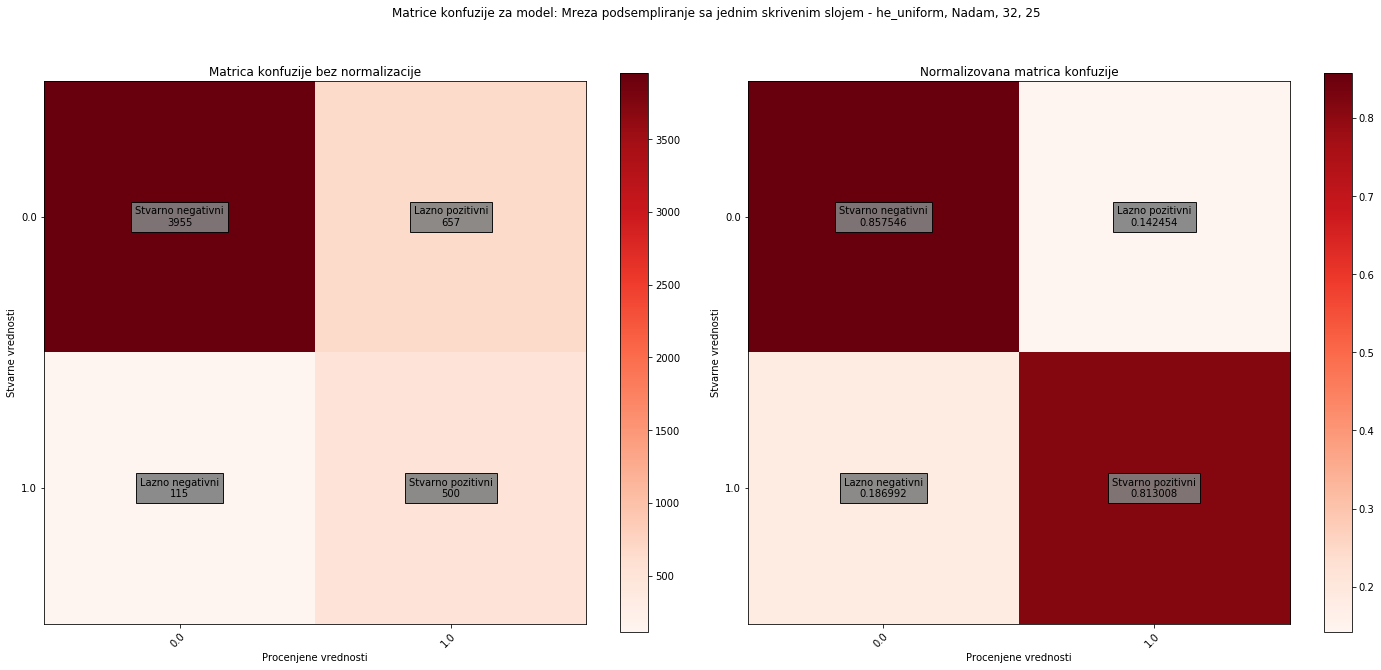

In [94]:
ime = 'Mreza podsempliranje sa jednim skrivenim slojem - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


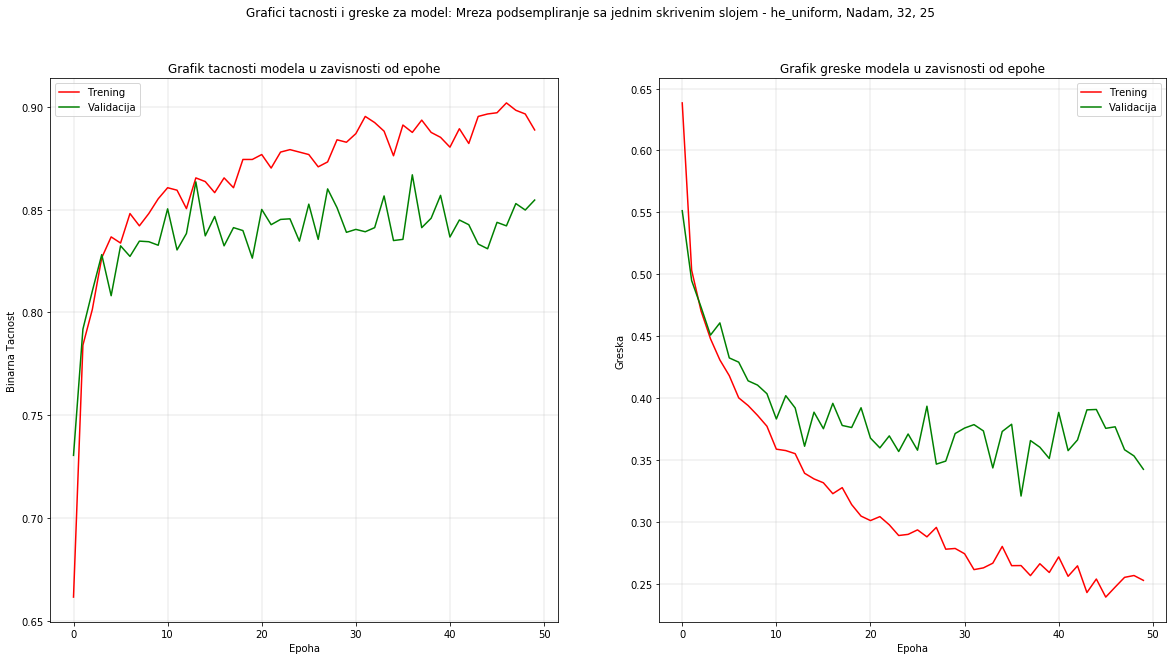

In [95]:
nacrtaj_ucenje (istorija, ime)


In [96]:
# Mreza sa dva skrivena sloja
# Vreme izvrsavanja ~ 46 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_pod, y_trening_pod, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_pod, y_trening_pod, x_valid, y_valid, x_test, y_test, 2)


Ukupan broj prolaza: 72
Novi f1 skor: 0.5501312335958005
Novi f1 skor: 0.5683736634777715
Novi f1 skor: 0.5732337736932799
Novi f1 skor: 0.5859872611464968
Prolaz: 18
Novi f1 skor: 0.5944997074312464
Prolaz: 36
Prolaz: 54
Proteklo vreme: 0:45:59.847421
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'glorot_normal', 'batch_size': 32, 'br_n_1': 25, 'br_n_2': 18}


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']


In [98]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_pod = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_pod.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                1100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                468       
_________________________________________________________________
batch_normalization_2 (Batch (None, 18)                72        
_________________________________________________________________
activation_2 (Activation)    (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [99]:
istorija = mreza_pod.fit (x_trening_pod, y_trening_pod, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 1672 samples, validate on 3502 samples
Epoch 1/200
1672/1672 [==============================] - 2s 987us/step - loss: 0.5720 - binary_accuracy: 0.7189 - val_loss: 0.4595 - val_binary_accuracy: 0.8187
Epoch 2/200
1672/1672 [==============================] - 1s 524us/step - loss: 0.4764 - binary_accuracy: 0.7978 - val_loss: 0.4507 - val_binary_accuracy: 0.8275
Epoch 3/200
1672/1672 [==============================] - 1s 541us/step - loss: 0.4574 - binary_accuracy: 0.8062 - val_loss: 0.4343 - val_binary_accuracy: 0.8370
Epoch 4/200
1672/1672 [==============================] - 1s 494us/step - loss: 0.4284 - binary_accuracy: 0.8331 - val_loss: 0.4505 - val_binary_accuracy: 0.8141
Epoch 5/200
1672/1672 [==============================] - 1s 519us/step - loss: 0.4054 - binary_accuracy: 0.8409 - val_loss: 0.4367 - val_binary_accuracy: 0.8210
Epoch 6/200
1672/1672 [==============================] - 1s 504us/step - loss: 0.3904 - binary_accuracy: 0.8499 - val_loss: 0.4469 - val_binary_acc

In [100]:
y_procena = mreza_pod.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije podsemplirane potpuno povezane sa dva skrivena sloja mreze:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije podsemplirane potpuno povezane sa dva skrivena sloja mreze:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      4612
           1       0.47      0.80      0.59       615

    accuracy                           0.87      5227
   macro avg       0.72      0.84      0.76      5227
weighted avg       0.91      0.87      0.88      5227



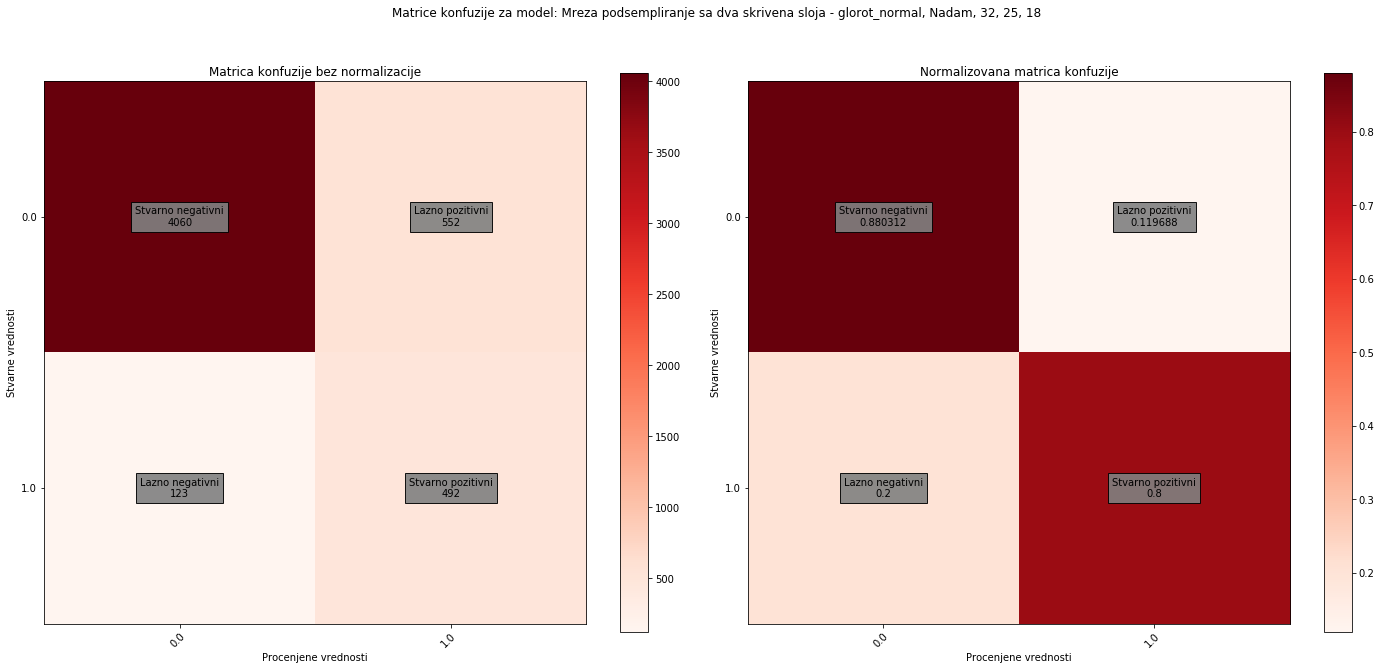

In [101]:
ime = 'Mreza podsempliranje sa dva skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


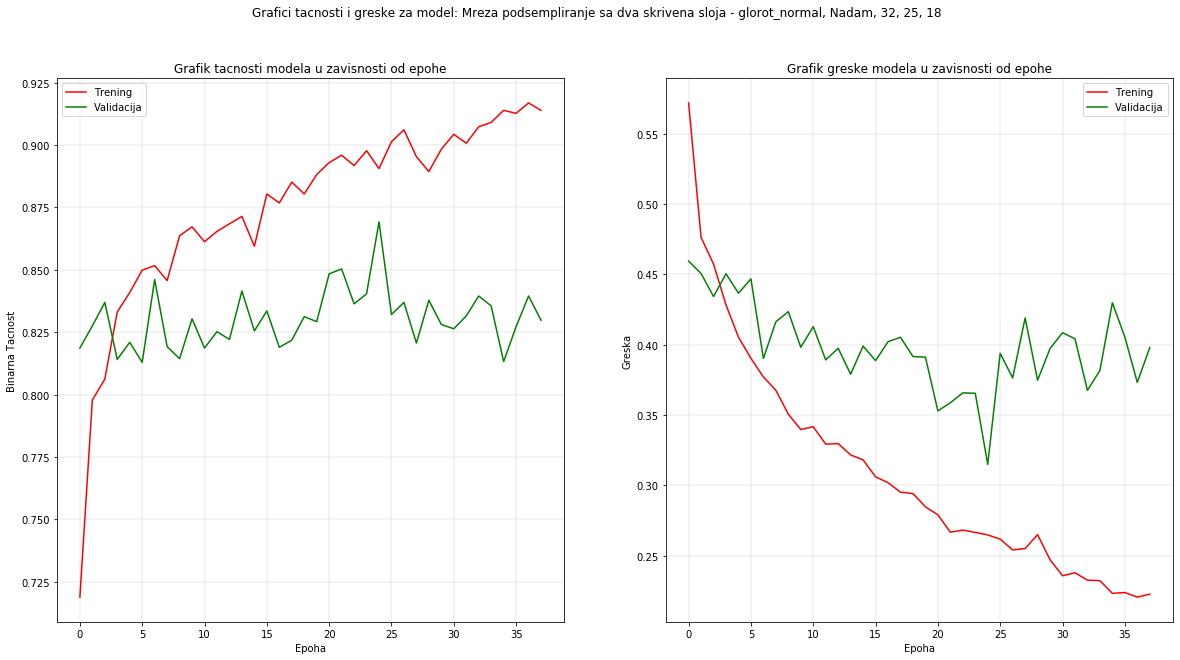

In [102]:
nacrtaj_ucenje (istorija, ime)


In [103]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~ 30 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_pod, y_trening_pod, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening_pod, y_trening_pod, x_valid, y_valid, x_test, y_test, 3)


'\nmreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)\n\nparametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)\n\nmreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, n_jobs = 1, cv = 2, verbose = 1)\nmreza_2.fit (x_trening_pod, y_trening_pod, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)\n'

In [104]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

"\nnajb_opt = mreza_2.best_params_['optimizer']\nnajb_inic = mreza_2.best_params_['kernel_initializer']\nnajb_vel = mreza_2.best_params_['batch_size']\nnajb_br_neur_1 = mreza_2.best_params_['br_neur_1']\nnajb_br_neur_2 = mreza_2.best_params_['br_neur_2']\nnajb_br_neur_3 = mreza_2.best_params_['br_neur_3']\n\nprint ('Najbolji parametri mreze su:')\nprint ('Kernel initializer:', najb_inic)\nprint ('Optimizer:', najb_opt)\nprint ('Batch size:', najb_vel)\nprint ('Broj neurona prvog sloja:', najb_br_neur_1)\nprint ('Broj neurona drugog sloja:', najb_br_neur_2)\nprint ('Broj neurona treceg sloja:', najb_br_neur_3)\n\n\nnajb_opt = najb_parametri['opt']\nnajb_inic = najb_parametri['kern_ini']\nnajb_vel = najb_parametri['batch_size']\nnajb_br_neur_1 = najb_parametri['br_n_1']\nnajb_br_neur_2 = najb_parametri['br_n_2']\nnajb_br_neur_3 = najb_parametri['br_n_3']\n"

In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_pod = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_pod.summary()


In [0]:
#istorija = mreza_pod.fit (x_trening_pod, y_trening_pod, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [105]:
'''
y_procena = mreza_pod.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije podsemplirane potpuno povezane sa tri skrivena sloja mreze:\n', met.classification_report (y_test, y_procena_zaok))
'''

"\ny_procena = mreza_pod.predict(x_test)\ny_procena_zaok = np.rint (y_procena)\n\nprint ('Izvestaj klasifikacije podsemplirane potpuno povezane sa tri skrivena sloja mreze:\n', met.classification_report (y_test, y_procena_zaok))\n"

In [106]:
'''
ime = 'Mreza podsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''


"\nime = 'Mreza podsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))\nnacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)\nplt.show()\n"

In [0]:
#nacrtaj_ucenje (istorija, ime)


## 3.3. Polazni skup podataka koji je balansiran SMOTE nadsempliranjem

In [107]:
# Mreza sa jednim skrivenim slojem
# Vreme izvrsavanja ~ 46 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_smote, y_trening_nad_smote, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_nad_smote, y_trening_nad_smote, x_valid, y_valid, x_test, y_test, 1)


Ukupan broj prolaza: 24
Novi f1 skor: 0.6340782122905027
Novi f1 skor: 0.645819170632223
Prolaz: 6
Novi f1 skor: 0.666207845836201
Prolaz: 12
Prolaz: 18
Proteklo vreme: 0:46:08.115822
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'glorot_uniform', 'batch_size': 32, 'br_n_1': 30}


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [109]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_smote = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_nad_smote.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,475
Trainable params: 1,413
Non-trainable params: 62
___________________________________________________

In [110]:
istorija = mreza_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 12544 samples, validate on 3502 samples
Epoch 1/200
12544/12544 [==============================] - 5s 369us/step - loss: 0.4569 - binary_accuracy: 0.8120 - val_loss: 0.3736 - val_binary_accuracy: 0.8549
Epoch 2/200
12544/12544 [==============================] - 4s 298us/step - loss: 0.3451 - binary_accuracy: 0.8687 - val_loss: 0.3432 - val_binary_accuracy: 0.8592
Epoch 3/200
12544/12544 [==============================] - 4s 297us/step - loss: 0.3032 - binary_accuracy: 0.8846 - val_loss: 0.2928 - val_binary_accuracy: 0.8886
Epoch 4/200
12544/12544 [==============================] - 4s 300us/step - loss: 0.2757 - binary_accuracy: 0.8942 - val_loss: 0.3152 - val_binary_accuracy: 0.8664
Epoch 5/200
12544/12544 [==============================] - 4s 288us/step - loss: 0.2664 - binary_accuracy: 0.8972 - val_loss: 0.2624 - val_binary_accuracy: 0.8921
Epoch 6/200
12544/12544 [==============================] - 4s 309us/step - loss: 0.2529 - binary_accuracy: 0.9022 - val_loss: 0.2859 - v

In [111]:
y_procena = mreza_nad_smote.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa jednim skrivenim slojem:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa jednim skrivenim slojem:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      4612
           1       0.58      0.76      0.66       615

    accuracy                           0.91      5227
   macro avg       0.77      0.84      0.80      5227
weighted avg       0.92      0.91      0.91      5227



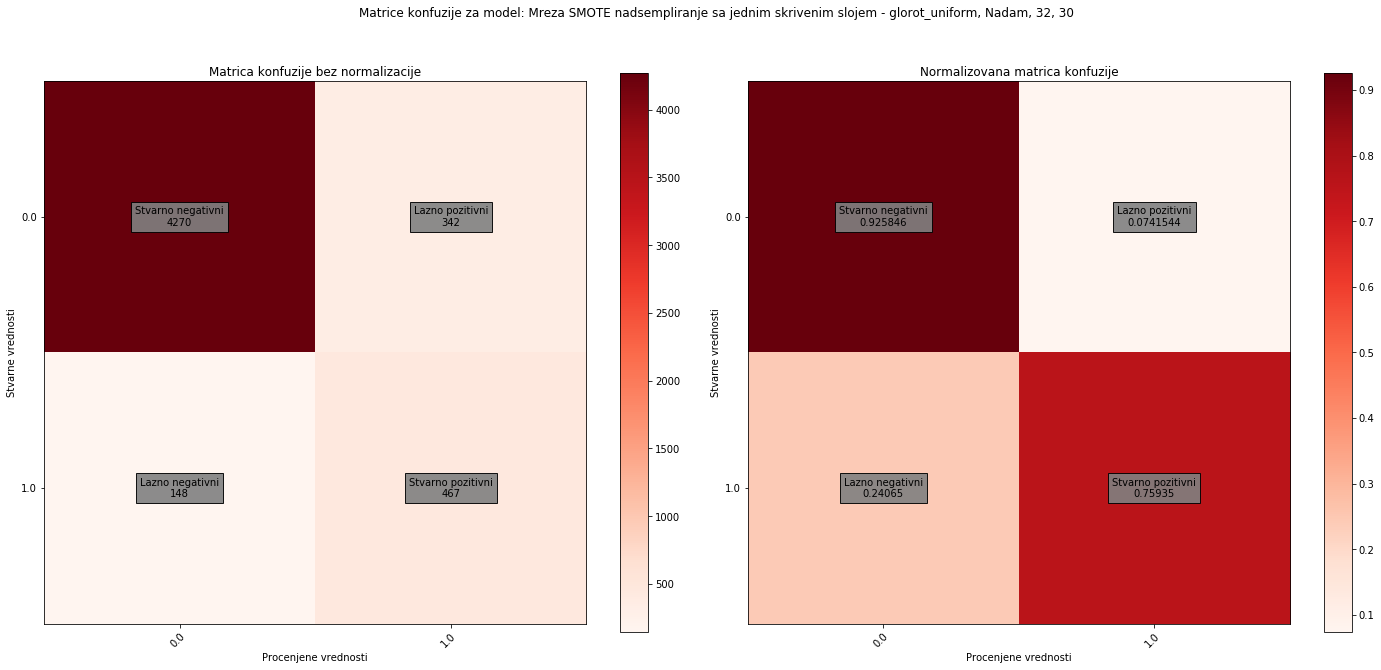

In [112]:
ime = 'Mreza SMOTE nadsempliranje sa jednim skrivenim slojem - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


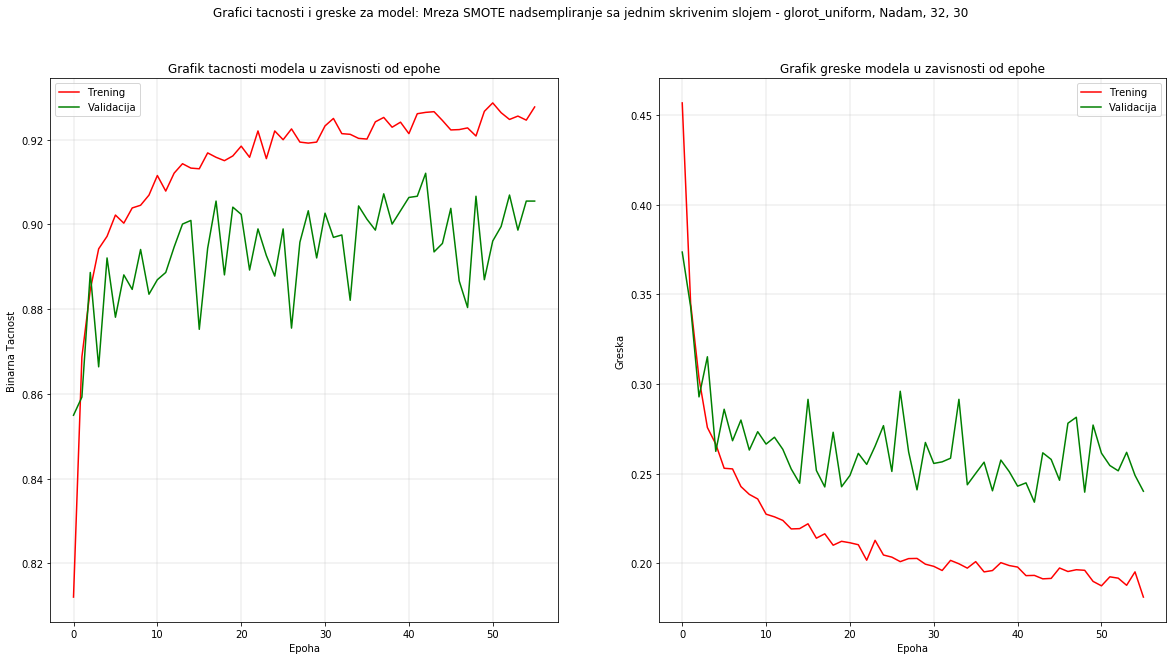

In [113]:
nacrtaj_ucenje (istorija, ime)


In [0]:
# Mreza sa dva skrivena sloja
# Vreme izvrsavanja ~ 2h 26 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_smote, y_trening_nad_smote, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_nad_smote, y_trening_nad_smote, x_valid, y_valid, x_test, y_test, 2)


Ukupan broj prolaza: 72
Novi f1 skor: 0.6539548022598869
Novi f1 skor: 0.6613138686131388
Novi f1 skor: 0.6652078774617068
Novi f1 skor: 0.6716754320060104
Novi f1 skor: 0.6729927007299271
Prolaz: 18
Novi f1 skor: 0.6765140324963073
Novi f1 skor: 0.6768115942028986


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']


In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_smote = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_nad_smote.summary()


In [0]:
istorija = mreza_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [0]:
y_procena = mreza_nad_smote.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa dva skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

In [0]:
ime = 'Mreza SMOTE nadsempliranje sa dva skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


In [0]:
nacrtaj_ucenje (istorija, ime)


In [0]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~  min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_smote, y_trening_nad_smote, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening_nad_smote, y_trening_nad_smote, x_valid, y_valid, x_test, y_test, 3)


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_nad_smote = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_nad_smote.summary()


In [0]:
#istorija = mreza_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [0]:
'''
y_procena = mreza_nad_smote.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))
'''

In [0]:
'''
ime = 'Mreza SMOTE nadsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''

In [0]:
#nacrtaj_ucenje (istorija, ime)


## 3.4. Polazni skup podataka koji je balansiran ADASYN nadsempliranjem

In [0]:
# Mreza sa jednim skrivenim slojem
# Vreme izvrsavanja ~ 46 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_nad_adasyn, y_trening_nad_adasyn, x_valid, y_valid, x_test, y_test, 1)


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_adasyn = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_nad_adasyn.summary()


In [0]:
istorija = mreza_nad_adasyn.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [0]:
y_procena = mreza_nad_adasyn.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa jednim skrivenim slojem:\n', met.classification_report (y_test, y_procena_zaok))

In [0]:
ime = 'Mreza ADASYN nadsempliranje sa jednim skrivenim slojem - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


In [0]:
nacrtaj_ucenje (istorija, ime)


In [0]:
# Mreza sa dva skrivena sloja
# Vreme izvrsavanja ~ 3h 40 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_nad_adasyn, y_trening_nad_adasyn, x_valid, y_valid, x_test, y_test, 2)


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']


In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_adasyn = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_nad_adasyn.summary()


In [0]:
istorija = mreza_nad_adasyn.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [0]:
y_procena = mreza_nad_adasyn.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa dva skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

In [0]:
ime = 'Mreza ADASYN nadsempliranje sa dva skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


In [0]:
nacrtaj_ucenje (istorija, ime)


In [0]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~  min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening_nad_adasyn, y_trening_nad_adasyn, x_valid, y_valid, x_test, y_test, 3)


In [0]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_nad_adasyn = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_nad_adasyn.summary()


In [0]:
#istorija = mreza_nad_adasyn.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [0]:
'''
y_procena = mreza_nad_adasyn.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))
'''

In [0]:
'''
ime = 'Mreza ADASYN nadsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''

In [0]:
#nacrtaj_ucenje (istorija, ime)


In [0]:
######################################################################################
######################################################################################
######################################################################################




# Testiranje nakon mejla





######################################################################################
######################################################################################
######################################################################################

In [0]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~  min.

br_neurona_1_temp = [100, 200, 400]
br_neurona_2_temp = [30, 60, 90]
br_neurona_3_temp = [7, 14, 28]

mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1_temp, br_neur_2 = br_neurona_2_temp, br_neur_3 = br_neurona_3_temp, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_smote, y_trening_nad_smote, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)


In [0]:
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


In [0]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_smote = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
mreza_nad_smote.summary()


In [0]:
istorija = mreza_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [0]:
y_procena = mreza_nad_smote.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

In [0]:
ime = 'Mreza SMOTE nadsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


In [0]:
nacrtaj_ucenje (istorija, ime)
